<a href="https://colab.research.google.com/github/dkalenov/Bicycle-Sharing-Prediction-Models/blob/main/Bicycle_sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Data](https://raw.githubusercontent.com/dkalenov/Bicycle-Sharing-Prediction-Models/main/seoul_bike_data.csv) of a bicycle rental service in Korea over the year.

Data description:
- Date - date(DD/MM/YYYY);
- Rented Bike Count - how many bicycles were rented, target variable;
- Hour - hour of the day (24 time zone);
- Temperature - air temperature in degrees Celsius;
- Humidity - air humidity;
- Wind Speed - wind speed in m/s;
- Visibility - a measure of the visibility of objects at a distance of 10 meters;
- Dew point temperature - temperature recorded at the beginning of the day, in degrees Celsius;
- Solar Radiation - intensity of sunlight;
- Rainfall - amount of precipitation in mm;
- Snowfall - amount of snow fallen in mm;
- Seasons - time of year;
- Holiday - whether the day is a holiday;
- Functioning Day - marker whether the rental service was working at the specified time.

Goal of the work: study data and identify factors influencing the demand for bicycles.

Tasks:
1.  Pre-process the data: check the data for outliers, erroneous values, omissions, duplicates and incorrect types.
2. Conduct EDA: implement all levels of analysis (univariate/multidimensional) using visualizations, study the distributions and relationships of features.
3. Prepare data for building a model (feature coding, scaling, splitting the sample into training and testing).
4. Implement a basic regression model for predicting the number of bicycles rented.
5. Using the Feature Selection tools and hyperparameter selection, select the best predictive model based on adjusted R2 (main metric) and RMSE.Achieve adjusted R2 of at least 89%.

# Data preprocessing & EDA

## Functions for data processing and EDA

In [1]:
# Function for displaying basic information about the dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def basic_data_preprocessing(dataframe):
    # Convert all column titles to lowercase with "_" between words
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]

    # Basic information about the dataset
    rows_num, columns_num = dataframe.shape
    print(f'Number of records: {rows_num}')
    print(f'Number of columns: {columns_num}\n')
    print('-' * 75)

    # Dataset information
    print("\nDataset Information:")
    display(dataframe.info())
    print()
    print('-' * 75)

    # Checking for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values:")
        display(pd.DataFrame(missing_values, columns=['Missing Count']))
        display(dataframe[dataframe.isna().any(axis=1)])
    else:
        print("No missing values.")
    print('-' * 75)

    # Checking for zero-filled columns
    zero_columns = dataframe.columns[(dataframe == 0.0).any()]
    zero_count = dataframe[zero_columns].apply(lambda x: x.value_counts().get(0, 0))
    if zero_count.sum() != 0:
        print('Rows with value 0 found:')
        display(pd.DataFrame(zero_count, columns=['Zero Count']))
    else:
        print('No rows with value 0.')
    print('-' * 75)

    # Checking for duplicates
    if dataframe.duplicated().sum() > 0:
        print("Duplicate data found. Number of duplicates:", dataframe.duplicated().sum())
        display(dataframe[dataframe.duplicated(keep=False)])
    else:
        print("No duplicates found.")
    print('-' * 75)

    # Checking for negative values in the dataframe
    # Excluding columns with string data type (object type)
    dataframe_digits = dataframe.select_dtypes(exclude=['object'])
    if (dataframe_digits < 0).sum().sum() > 0:
        print("Negative values found:")
        display(pd.DataFrame((dataframe_digits < 0).sum(), columns=['Negative Value Count']))
    else:
        print('No negative values found.')
    print('-' * 75)

    # Statistical description of the data
    print("\nStatistical Description of the Data:\n")
    display(dataframe.describe())
    print('-' * 75)

    # Data Distribution
    print("\nData Distribution:")

    # Determine the number of graphs and rows for the subplots
    num_graphs = len(dataframe.columns)
    num_rows = (num_graphs + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))

    for i, column in enumerate(dataframe.columns):
        ax = axes[i // 2, i % 2]  # Get the current axis from the subplot grid

        # Categorical feature: countplot
        if dataframe[column].dtype == 'object':
            sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
            ax.tick_params(axis='x')
            total = float(len(dataframe[column]))
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

        # Numeric feature with less than 8 unique values: countplot
        else:
            if len(dataframe[column].unique()) < 8:
                sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
                ax.tick_params(axis='x')
                total = float(len(dataframe[column]))
                for p in ax.patches:
                    height = p.get_height()
                    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
            else:
                sns.histplot(data=dataframe, x=column, kde=True, ax=ax, color='dodgerblue')
                ax.axvline(dataframe[column].mean(), color='red', linestyle='--')
        # Set visualization properties for the current axis
        ax.grid(False)
        ax.set_title(column)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_facecolor('white')
        ax.tick_params(top=False, bottom=False, left=False, right=False)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

In [2]:
# Function for compression of the data type of columns in a pandas DataFrame

import pandas as pd
import numpy as np

def data_type_compression(dataframe):

    for column in dataframe.columns:
        unique_values = dataframe[column].unique()

        # Check if the column has two unique values (potentially a boolean column)
        # Uncomment the code below if you want to convert such columns to boolean type
        # if len(unique_values) == 2:
        #   dataframe[column] = dataframe[column].astype(bool)

        # Check if the column has an integer data type
        if dataframe[column].dtype == int:
            max_value = np.max(dataframe[column])

            # Assign the appropriate integer type based on the maximum value in the column
            if max_value <= np.iinfo(np.int8).max:
                dataframe[column] = dataframe[column].astype(np.int8)
            elif max_value <= np.iinfo(np.int16).max:
                dataframe[column] = dataframe[column].astype(np.int16)
            elif max_value <= np.iinfo(np.int32).max:
                dataframe[column] = dataframe[column].astype(np.int32)
            else:
                dataframe[column] = dataframe[column].astype(np.int64)

        # Check if the column has a float data type
        elif dataframe[column].dtype == float:
            max_value = np.max(dataframe[column])

            # Assign the appropriate float type based on the maximum value in the column
            if max_value <= np.finfo(np.float16).max:
                dataframe[column] = dataframe[column].astype(np.float16)
            elif max_value <= np.finfo(np.float32).max:
                dataframe[column] = dataframe[column].astype(np.float32)
            else:
                dataframe[column] = dataframe[column].astype(np.float64)

In [4]:
# Function for visualizing the distribution of different features by a target feature

import matplotlib.pyplot as plt
import seaborn as sns

def data_distribution_by_target(dataframe, target_feature):
    for column in dataframe.columns:
        if column != target_feature:
            # Create a new figure with size (8, 6)
            plt.figure(figsize=(8, 6))

            # Set style for grid (white with no grid lines)
            sns.set_style("whitegrid", {'axes.grid': False})

            # Categorical feature: barplot
            if dataframe[column].dtype == 'object':
                #plt.xticks(rotation=45, ha='right')
                plot = sns.barplot(x=column, y=target_feature, data=dataframe)

            # Date/time feature: lineplot
            elif dataframe[column].dtype == 'datetime64[ns]':
                plt.xticks(rotation=45, ha='right')
                plot = sns.lineplot(x=column, y=target_feature, data=dataframe)

            # Boolean feature: barplot
            elif dataframe[column].dtype == 'bool':
                plt.xticks([0, 1], ['False', 'True'])
                #plt.xticks(rotation=45, ha='right')
                plot = sns.barplot(x=column, y=target_feature, data=dataframe)

            # Numeric feature: histogram with kernel density estimation (kde)
            elif dataframe[column].dtype in ['float64', 'float32', 'float16']:
                # Determine the number of bins for the histogram
                n_bins = min(30, len(dataframe[column].unique()))
                # Calculate the bin width and range
                binwidth = (dataframe[column].max() - dataframe[column].min()) / n_bins
                binrange = (dataframe[column].min(), dataframe[column].max())
                # Create a histogram with KDE
                sns.histplot(data=dataframe, x=column, bins=n_bins, binwidth=binwidth, binrange=binrange, kde=True, cumulative=False)
                plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)   # Add a vertical line at the mean value
                #plt.xticks(rotation=45, ha='right')

            # Other feature types: scatterplot with regression line or countplot
            else:
                if dataframe[column].nunique() > 6:
                    # Create a scatterplot with regression line
                    plot = sns.scatterplot(data=dataframe, x=column, y=target_feature, alpha=0.7)
                    sns.regplot(data=dataframe, x=column, y=target_feature, scatter=False, lowess=True, line_kws={"color": "C1"})
                    # plt.xticks(rotation=45, ha='right')
                    plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)
                else:
                    # Create a countplot
                    plot = sns.countplot(data=dataframe, x=column, y=target_feature)

            plot.set_title(f'Data Distribution by {target_feature}: {column}')  # Set title
            plot.set_xlabel(column)  # Set x-axis label
            plot.set_ylabel(target_feature)  # Set y-axis label
            plt.tight_layout() # Adjust plot layout
            plt.show()

In [59]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype != 'object' and len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)

In [80]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

In [103]:
# Function to find multicollinearity and print correlation matrix

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix

def find_multicollinearity(dataframe, method='phik', threshold=0.8):
    # Convert method to lowercase
    method = method.lower()

    # Calculate correlation matrix using specified sort method


    if method in ['pearson', 'kendall', 'spearman']:
        corr_matrix = dataframe.corr(method=method).abs()
    else:
        interval_cols = [col for col in dataframe.columns]
        corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)

    # Exclude correlation of a variable with itself
    np.fill_diagonal(corr_matrix.values, np.NaN)

    # Create a larger figure size based on the number of features
    n = corr_matrix.shape[0]
    fig_width = 6 + n * 0.5
    fig_height = 4 + n * 0.3

    # Plot correlation matrix as heatmap with adjusted figure size
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
    plt.title("Correlation Matrix")
    plt.show()

    # Initialize an empty list to store multicollinear features
    multicollinear_table = []

    # Iterate through each pair of multicollinear features and their correlation percentages
    for i in range(n):
        for j in range(i+1, n):
            # Check if the correlation between the two features is above the threshold
            if corr_matrix.iloc[i, j] > threshold:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                # Append the pair of multicollinear features and their correlation percentage to the list
                multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

    # Create a dataframe from the list of multicollinear features
    multicollinear_table = pd.DataFrame(multicollinear_table)

    try:
        # Sort the multicollinear table by correlation in descending order
        multicollinear_table = multicollinear_table.sort_values(by='correlation', ascending=False)
        # Return the correlation matrix and the multicollinear table
        display(multicollinear_table)
    except KeyError:
        print("No features with high multicollinearity")

## Data processing

In [25]:
import pandas as pd

url = 'https://raw.githubusercontent.com/dkalenov/Bicycle-Sharing-Prediction-Models/main/seoul_bike_data.csv'
data = pd.read_csv(url, encoding='latin1')
data.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

Number of records: 8760
Number of columns: 14

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented_bike_count          8760 non-null   int64  
 2   hour                       8760 non-null   int64  
 3   temperature(°c)            8760 non-null   float64
 4   humidity(%)                8760 non-null   int64  
 5   wind_speed_(m/s)           8760 non-null   float64
 6   visibility_(10m)           8760 non-null   int64  
 7   dew_point_temperature(°c)  8760 non-null   float64
 8   solar_radiation_(mj/m2)    8760 non-null   float64
 9   rainfall(mm)               8760 non-null   float64
 10  snowfall_(cm)              8760 non-null   float64
 11  seasons        

None


---------------------------------------------------------------------------
No missing values.
---------------------------------------------------------------------------
Rows with value 0 found:


Zero Count
rented_bike_count                 295
hour                              365
temperature(°c)                    21
humidity(%)                        17
wind_speed_(m/s)                   74
dew_point_temperature(°c)          60
solar_radiation_(mj/m2)          4300
rainfall(mm)                     8232
snowfall_(cm)                    8317

---------------------------------------------------------------------------
No duplicates found.
---------------------------------------------------------------------------
Negative values found:


Negative Value Count
rented_bike_count                             0
hour                                          0
temperature(°c)                            1433
humidity(%)                                   0
wind_speed_(m/s)                              0
visibility_(10m)                              0
dew_point_temperature(°c)                  3138
solar_radiation_(mj/m2)                       0
rainfall(mm)                                  0
snowfall_(cm)                                 0

---------------------------------------------------------------------------

Statistical Description of the Data:



rented_bike_count         hour  temperature(°c)  humidity(%)  \
count        8760.000000  8760.000000      8760.000000  8760.000000   
mean          704.602055    11.500000        12.882922    58.226256   
std           644.997468     6.922582        11.944825    20.362413   
min             0.000000     0.000000       -17.800000     0.000000   
25%           191.000000     5.750000         3.500000    42.000000   
50%           504.500000    11.500000        13.700000    57.000000   
75%          1065.250000    17.250000        22.500000    74.000000   
max          3556.000000    23.000000        39.400000    98.000000   

       wind_speed_(m/s)  visibility_(10m)  dew_point_temperature(°c)  \
count       8760.000000       8760.000000                8760.000000   
mean           1.724909       1436.825799                   4.073813   
std            1.036300        608.298712                  13.060369   
min            0.000000         27.000000                 -30.600000   
25%            0.900000        940.000000                  -4.700000   
50%            1.500000       1698.000000                   5.100000   
75%            2.300000       2000.000000                  14.800000   
max            7.400000       2000.000000                  27.200000   

       solar_radiation_(mj/m2)  rainfall(mm)  snowfall_(cm)  
count              8760.000000   8760.000000    8760.000000  
mean                  0.569111      0.148687       0.075068  
std                   0.868746      1.128193       0.436746  
min                   0.000000      0.000000       0.000000  
25%                   0.000000      0.000000       0.000000  
50%                   0.010000      0.000000       0.000000  
75%                   0.930000      0.000000       0.000000  
max                   3.520000     35.000000       8.800000

---------------------------------------------------------------------------

Data Distribution:


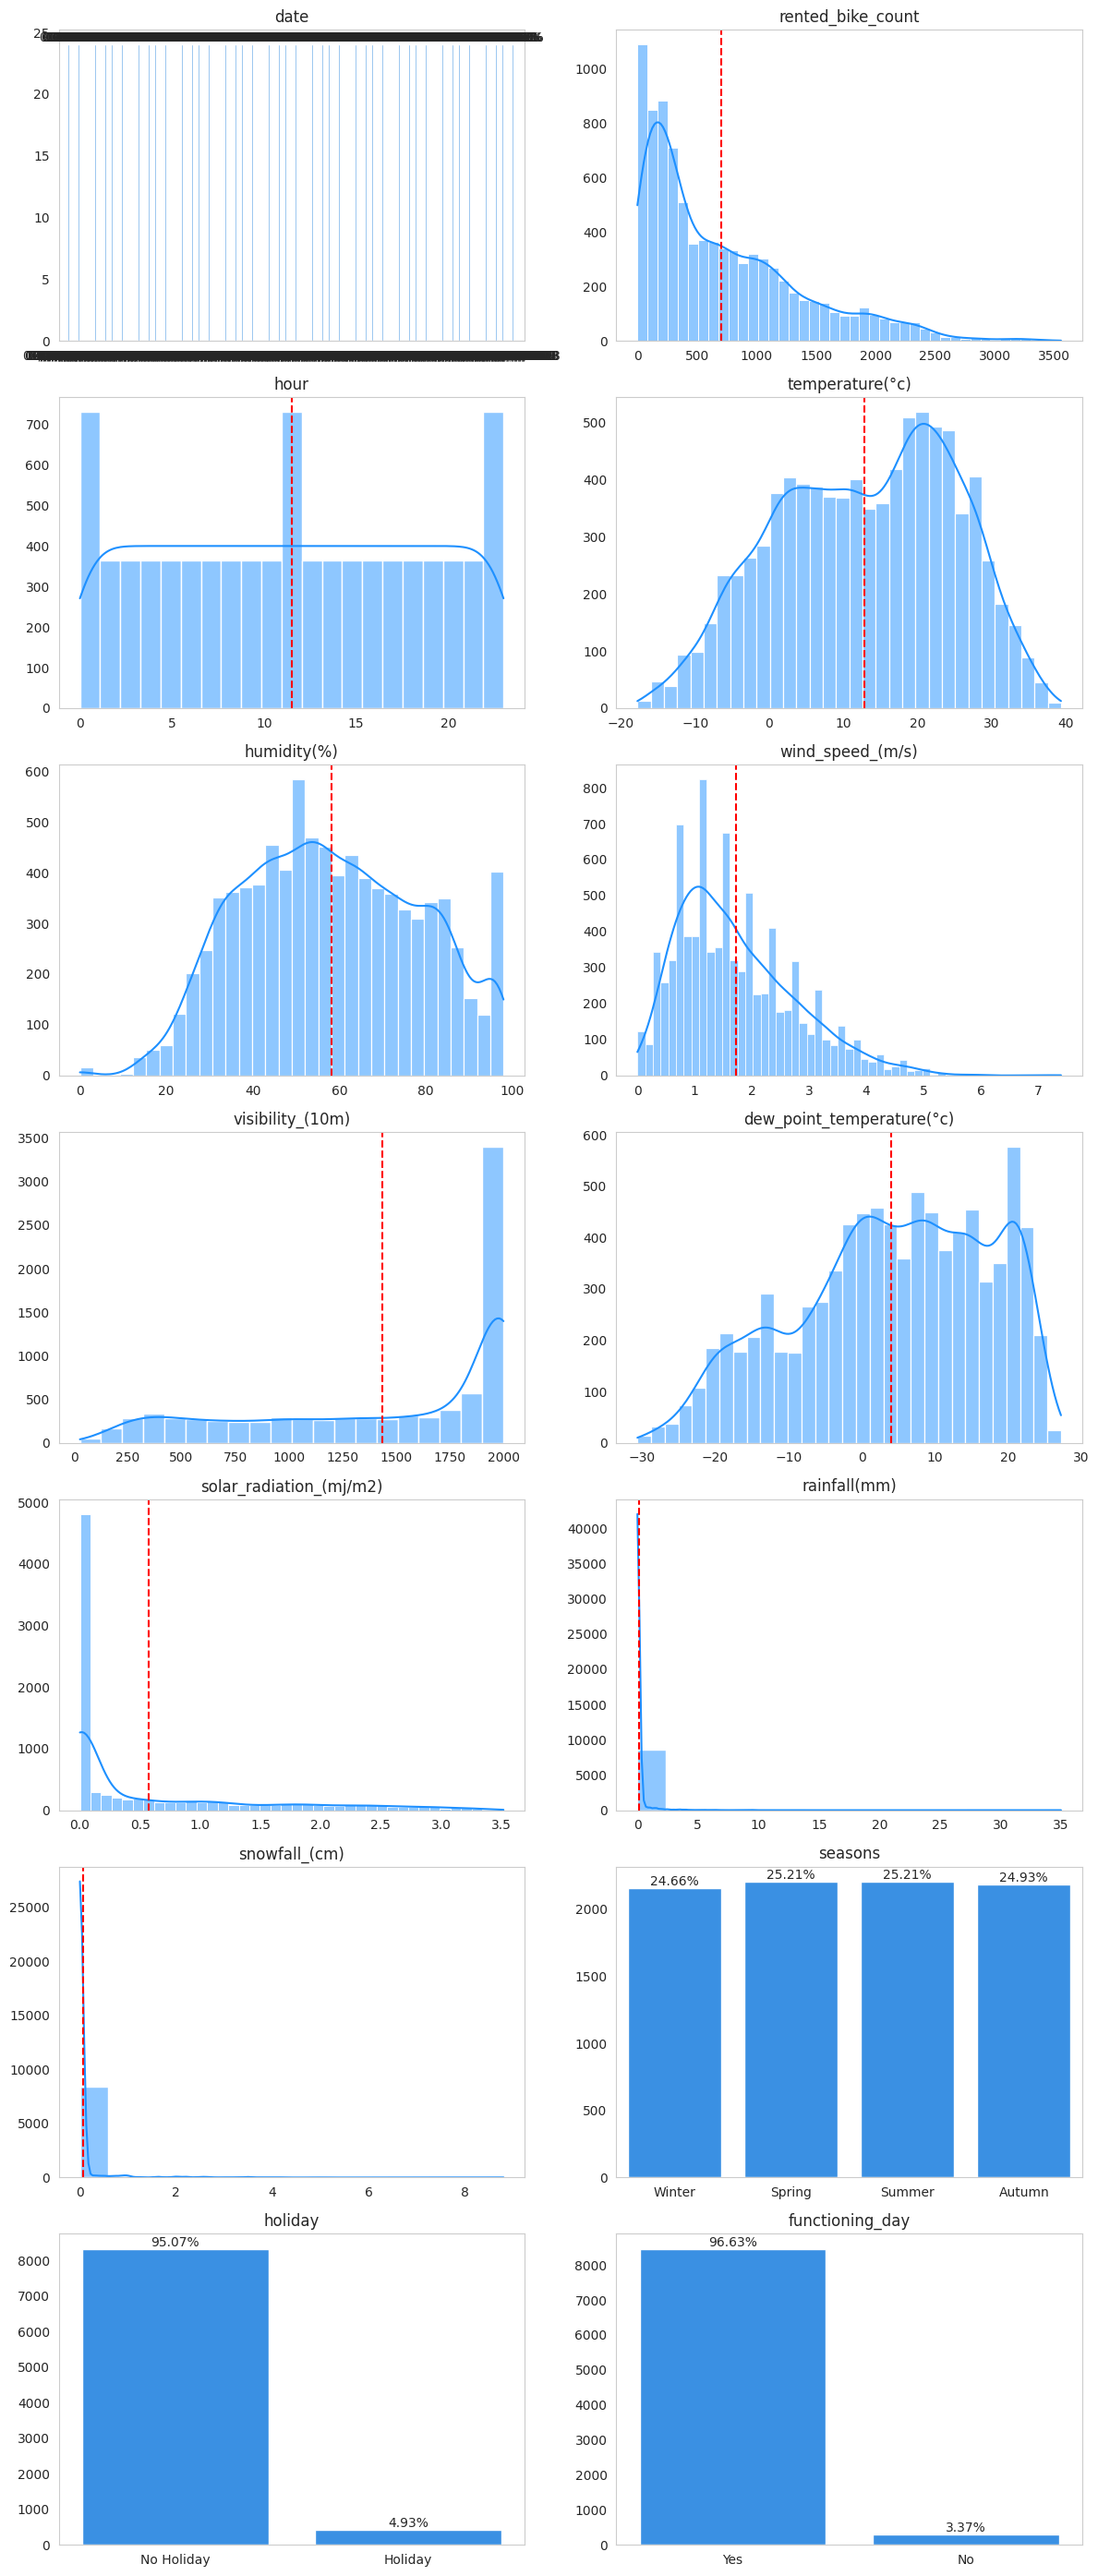

In [26]:
# Базовая информация о датасете
basic_data_preprocessing(data)

* All numerical data ('rented_bike_count', 'temperature(°c)', 'humidity(%)',
  'wind_speed_(m/s)', 'visibility_(10m)', 'dew_point_temperature(°c)', 'solar_radiation_(mj/m2)', 'rainfall(mm)', 'snowfall_(cm)') are not normally distributed. It is likely that scaling the data will increase the strength of the models;
* All categorical data, except 'holiday', are normally distributed in some proportion. The 'holiday' column greatly (hundreds of times) increases the number of non-working days compared to non-working days.

In [27]:
# make a copy of the dataframe
df = data.copy()

In [28]:
# compress int and float data
data_type_compression(df)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented_bike_count          8760 non-null   int16  
 2   hour                       8760 non-null   int8   
 3   temperature(°c)            8760 non-null   float16
 4   humidity(%)                8760 non-null   int8   
 5   wind_speed_(m/s)           8760 non-null   float16
 6   visibility_(10m)           8760 non-null   int16  
 7   dew_point_temperature(°c)  8760 non-null   float16
 8   solar_radiation_(mj/m2)    8760 non-null   float16
 9   rainfall(mm)               8760 non-null   float16
 10  snowfall_(cm)              8760 non-null   float16
 11  seasons                    8760 non-null   object 
 12  holiday                    8760 non-null   object 
 13  functioning_day            8760 non-null   objec

In [30]:
# Convert the data type for the 'date' column
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

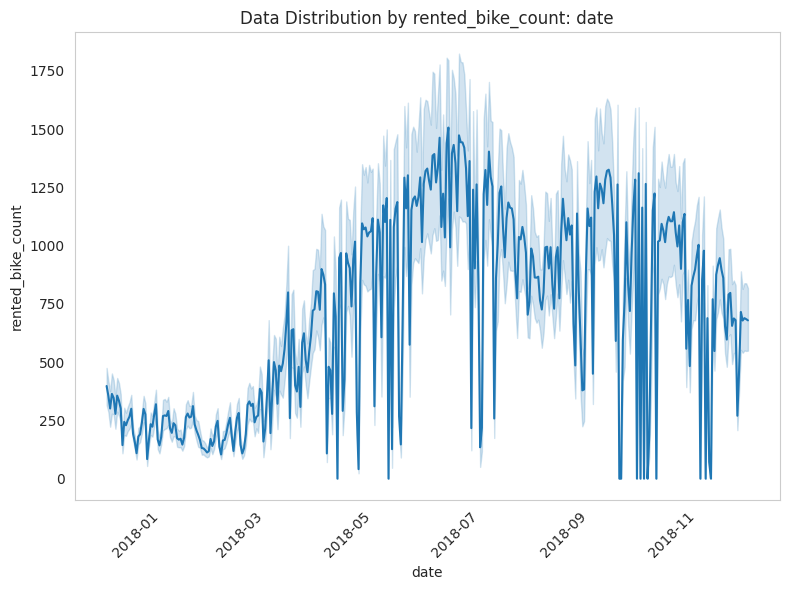

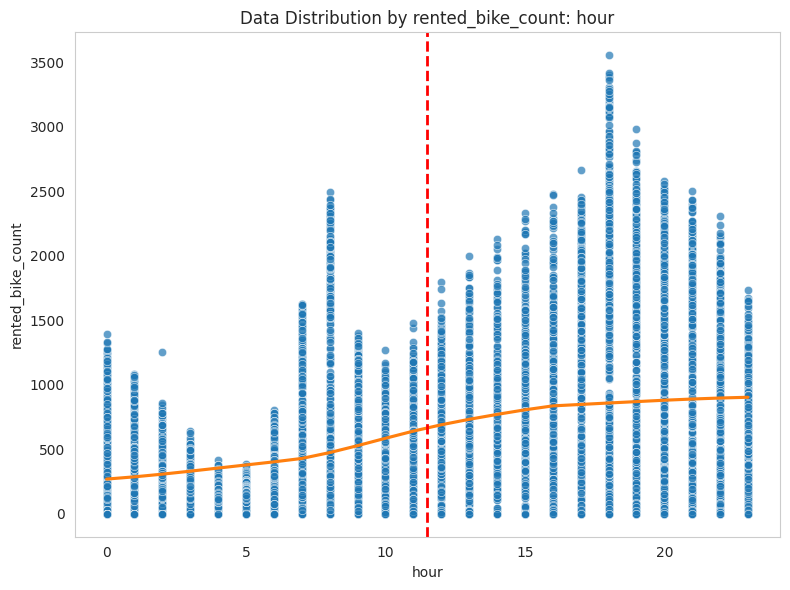

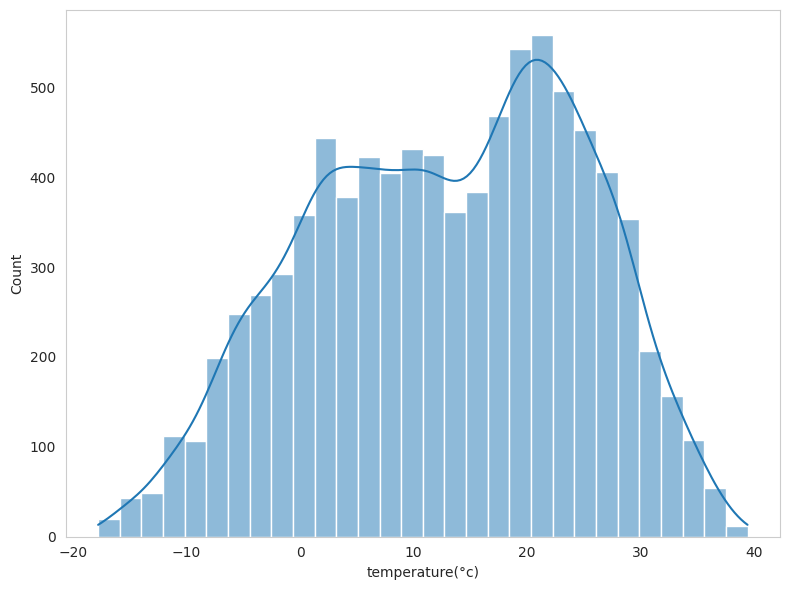

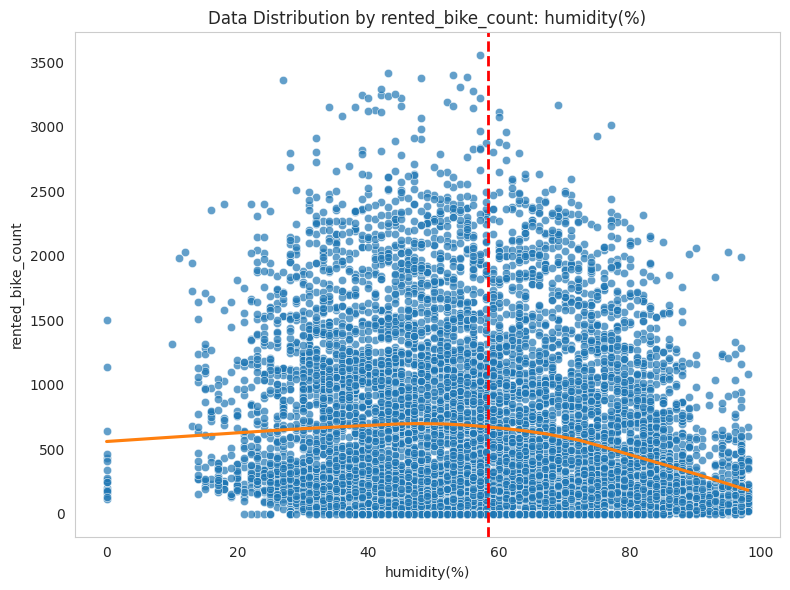

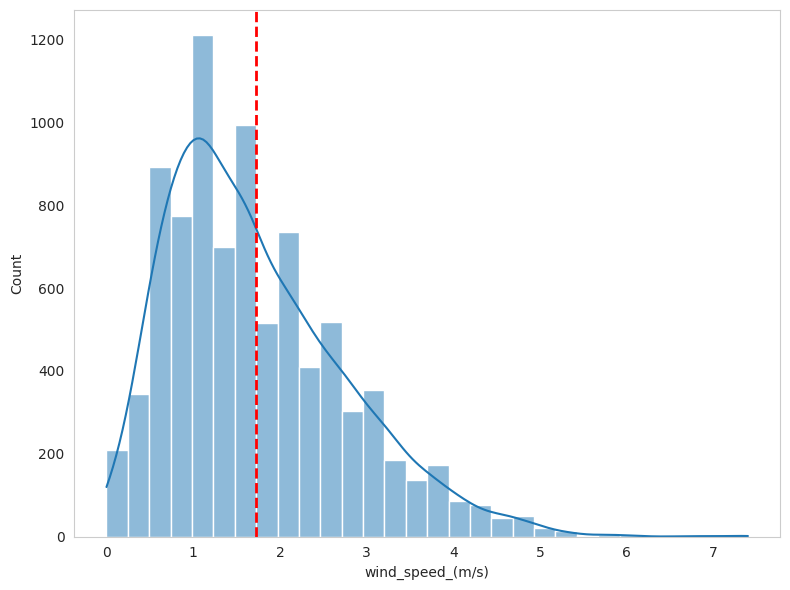

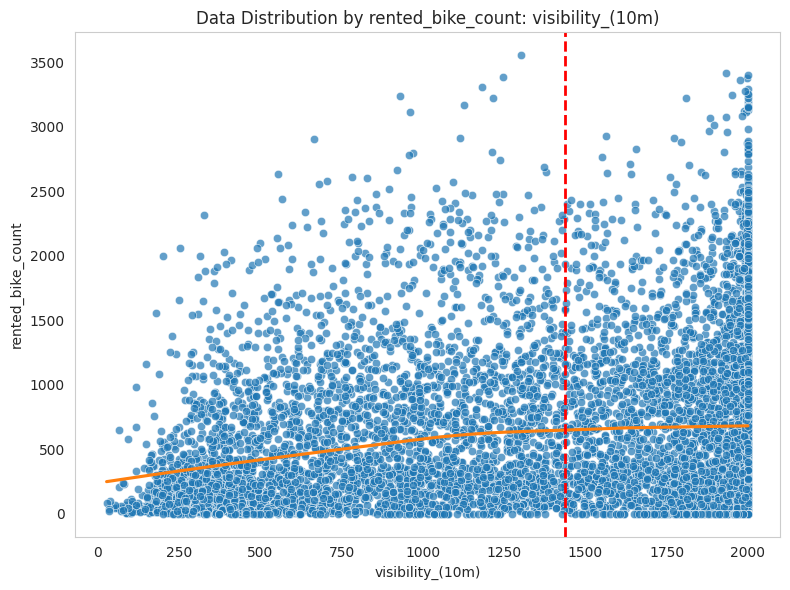

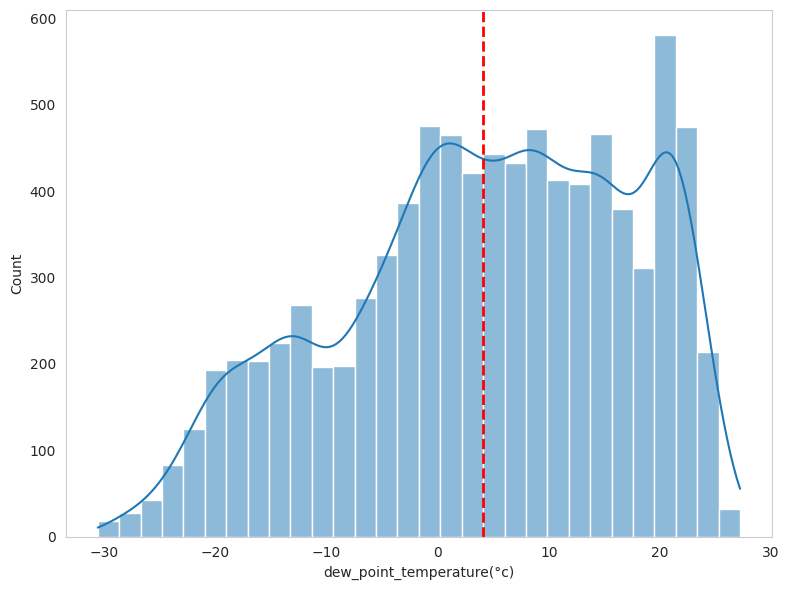

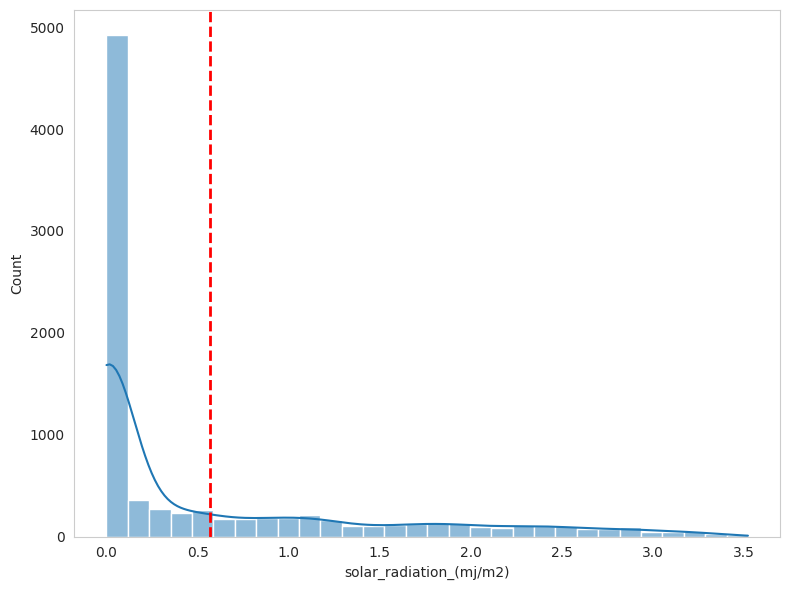

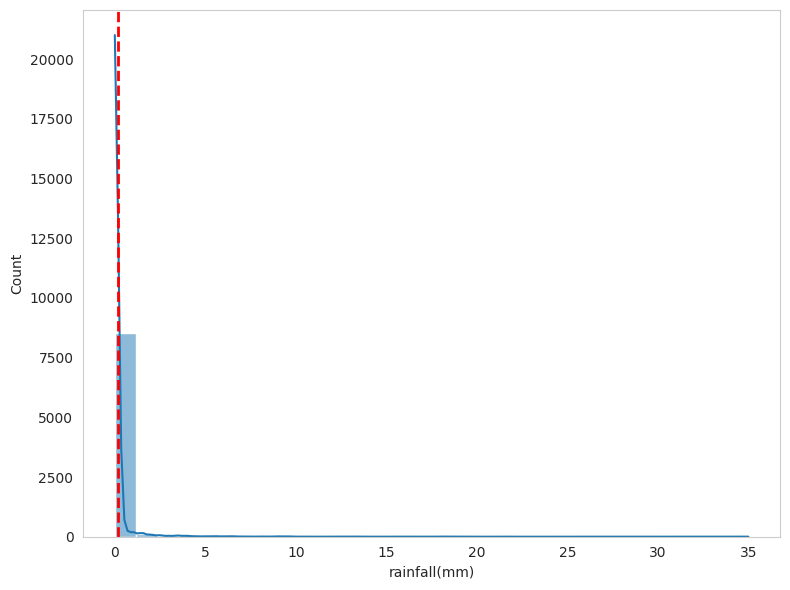

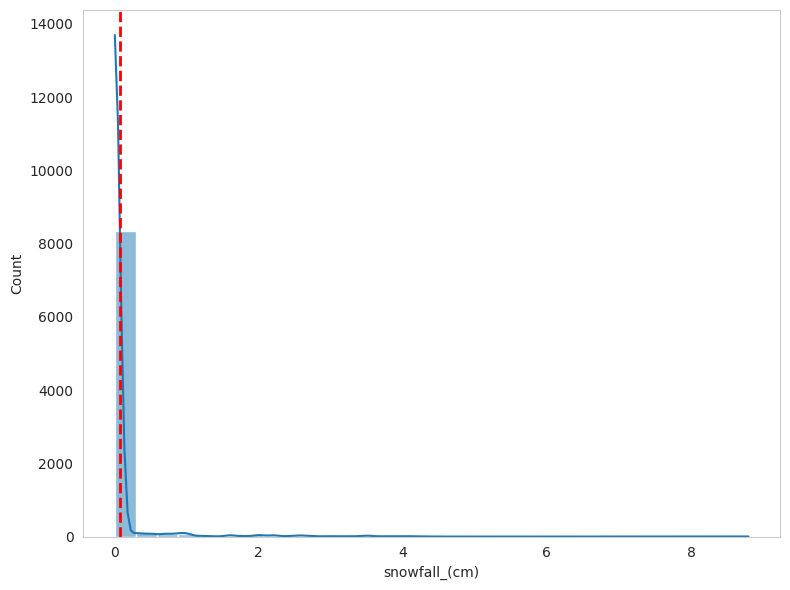

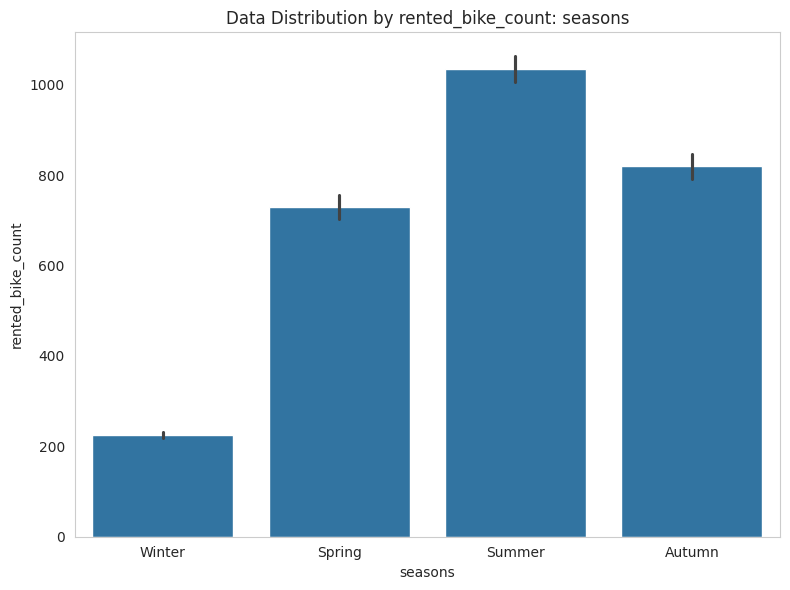

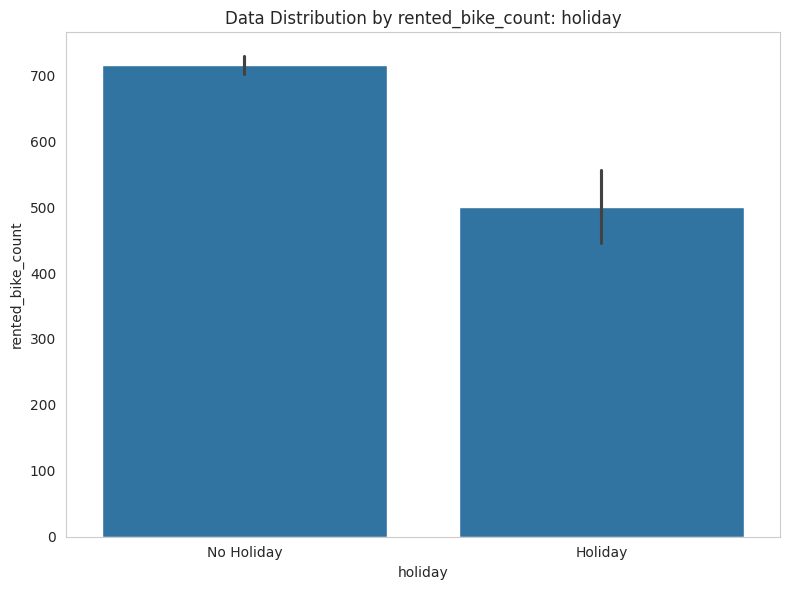

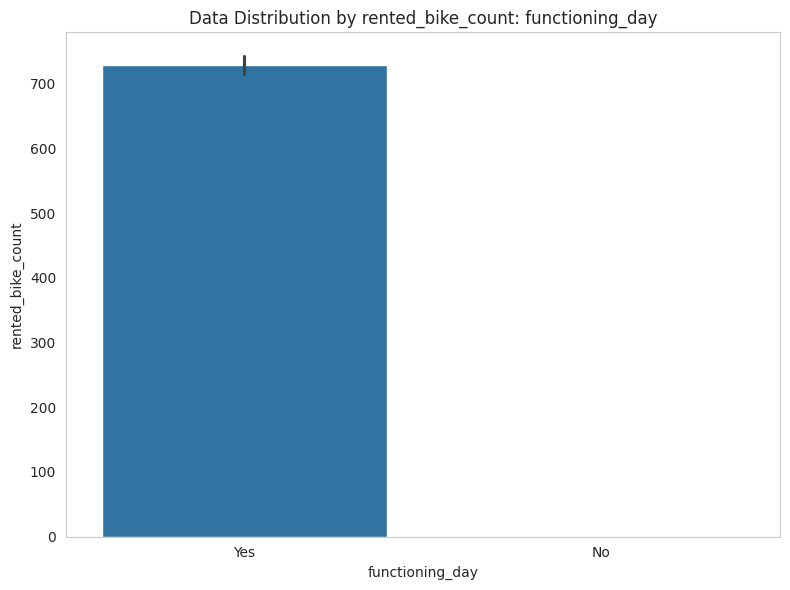

In [31]:
# dynamics of the target feature by other features
data_distribution_by_target(df, 'rented_bike_count')

In [32]:
# Make sure that there are no rented bikes on non-functioning days
df_filtered = df[(df['functioning_day'] == 'No') & (df['rented_bike_count'] > 0)]
df_filtered

Empty DataFrame
Columns: [date, rented_bike_count, hour, temperature(°c), humidity(%), wind_speed_(m/s), visibility_(10m), dew_point_temperature(°c), solar_radiation_(mj/m2), rainfall(mm), snowfall_(cm), seasons, holiday, functioning_day]
Index: []

Let's remove rows when the service was not working and then remove the 'functioning_day' column, since no bikes were rented on those days.

In [33]:
# Remove rows in which the value of the target parameter is 0
df = df[df['functioning_day'] != 'No']

In [34]:
# Remove the 'functioning_day' column
df = df.drop('functioning_day', axis=1)

In [35]:
# Check if there are still zero values in rented_bike_count
zero_count_df = df[df['rented_bike_count'] == 0]
zero_count_df

Empty DataFrame
Columns: [date, rented_bike_count, hour, temperature(°c), humidity(%), wind_speed_(m/s), visibility_(10m), dew_point_temperature(°c), solar_radiation_(mj/m2), rainfall(mm), snowfall_(cm), seasons, holiday]
Index: []

Let's try to group 'hour' by parts of the day: 'night' (from 0 to 6), 'morning' (from 6 to 12), 'aftenoon' (from 12 to 18), 'evening' (from 18 to 24). So, in theory, this can help to better summarize the data.

In [36]:
df.columns.tolist()

['date',
 'rented_bike_count',
 'hour',
 'temperature(°c)',
 'humidity(%)',
 'wind_speed_(m/s)',
 'visibility_(10m)',
 'dew_point_temperature(°c)',
 'solar_radiation_(mj/m2)',
 'rainfall(mm)',
 'snowfall_(cm)',
 'seasons',
 'holiday']

In [37]:
# Let's make a copy to compare later whether grouping by hour will have a positive effect
df_grouped = df.copy()

In [38]:
# create a new column 'time_group'
df_grouped['time_group'] = pd.cut(df_grouped['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)

In [39]:
# remove the 'hour' column
df_grouped = df_grouped.drop('hour', axis=1)

In [40]:
df_grouped.head(3)

date  rented_bike_count  temperature(°c)  humidity(%)  \
0 2017-12-01                254        -5.199219           37   
1 2017-12-01                204        -5.500000           38   
2 2017-12-01                173        -6.000000           39   

   wind_speed_(m/s)  visibility_(10m)  dew_point_temperature(°c)  \
0          2.199219              2000                 -17.593750   
1          0.799805              2000                 -17.593750   
2          1.000000              2000                 -17.703125   

   solar_radiation_(mj/m2)  rainfall(mm)  snowfall_(cm) seasons     holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   

  time_group  
0      night  
1      night  
2      night

Преобразуем даты в дни недели, чтобы исключить уникальные значения из датафреймов и лучше обобщить данные

In [41]:
# Convert dates to days of the week in both dataframes
df['date'] = pd.to_datetime(df['date']).dt.day_name()
df_grouped['date'] = pd.to_datetime(df_grouped['date']).dt.day_name()

In [42]:
# Encode categorical features in both dataframes
df = pd.get_dummies(df, columns=['date', 'seasons', 'holiday'], drop_first=True)
df_grouped = pd.get_dummies(df_grouped, columns=['date', 'time_group', 'seasons', 'holiday'], drop_first=True)

In [45]:
df.head(1)

rented_bike_count  hour  temperature(°c)  humidity(%)  wind_speed_(m/s)  \
0                254     0        -5.199219           37          2.199219   

   visibility_(10m)  dew_point_temperature(°c)  solar_radiation_(mj/m2)  \
0              2000                  -17.59375                      0.0   

   rainfall(mm)  snowfall_(cm)  date_Monday  date_Saturday  date_Sunday  \
0           0.0            0.0            0              0            0   

   date_Thursday  date_Tuesday  date_Wednesday  seasons_Spring  \
0              0             0               0               0   

   seasons_Summer  seasons_Winter  holiday_No Holiday  
0               0               1                   1

In [44]:
df_grouped.head(1)

rented_bike_count  temperature(°c)  humidity(%)  wind_speed_(m/s)  \
0                254        -5.199219           37          2.199219   

   visibility_(10m)  dew_point_temperature(°c)  solar_radiation_(mj/m2)  \
0              2000                  -17.59375                      0.0   

   rainfall(mm)  snowfall_(cm)  date_Monday  ...  date_Thursday  date_Tuesday  \
0           0.0            0.0            0  ...              0             0   

   date_Wednesday  time_group_morning  time_group_afternoon  \
0               0                   0                     0   

   time_group_evening  seasons_Spring  seasons_Summer  seasons_Winter  \
0                   0               0               0               1   

   holiday_No Holiday  
0                   1  

[1 rows x 22 columns]

In [46]:
# df colunms renaming

# Replace values in 'Holiday_No Holiday' column
df['holiday_No Holiday'] = df['holiday_No Holiday'].replace({0: 1, 1: 0})

# Rename columns for convenience
df = df.rename(columns={'holiday_No Holiday': 'holiday',
                        'temperature(°c)': 'temperature',
                        'humidity(%)': 'humidity',
                        'wind_speed_(m/s)': 'wind_speed',
                        'visibility_(10m)': 'visibility',
                        'dew_point_temperature(°c)': 'dew_point_temperature',
                        'solar_radiation_(mj/m2)': 'solar_radiation',
                        'rainfall(mm)': 'rainfall',
                        'snowfall_(cm)': 'snowfall',
                        'date_Monday': 'monday',
                        'date_Saturday': 'saturday',
                        'date_Sunday': 'sunday',
                        'date_Thursday': 'thursday',
                        'date_Tuesday': 'tuesday',
                        'date_Wednesday': 'wednesday',
                        'seasons_Spring': 'spring',
                        'seasons_Summer': 'summer',
                        'seasons_Winter': 'winter'
                        })

In [51]:
df.head(2)

rented_bike_count  hour  temperature  humidity  wind_speed  visibility  \
0                254     0    -5.199219        37    2.199219        2000   
1                204     1    -5.500000        38    0.799805        2000   

   dew_point_temperature  solar_radiation  rainfall  snowfall  date_monday  \
0              -17.59375              0.0       0.0       0.0            0   
1              -17.59375              0.0       0.0       0.0            0   

   date_saturday  date_sunday  date_thursday  date_tuesday  date_wednesday  \
0              0            0              0             0               0   
1              0            0              0             0               0   

   seasons_spring  seasons_summer  seasons_winter  holiday  
0               0               0               1        0  
1               0               0               1        0

In [54]:
# df_grouped colunms renaming

# Replace values in 'Holiday_No Holiday' column
df_grouped['holiday_No Holiday'] = df_grouped['holiday_No Holiday'].replace({0: 1, 1: 0})

df_grouped = df_grouped.rename(columns={'temperature(°c)': 'temperature',
                                        'humidity(%)': 'humidity',
                                        'wind_speed_(m/s)': 'wind_speed',
                                        'visibility_(10m)': 'visibility',
                                        'dew_point_temperature(°c)': 'dew_point_temperature',
                                        'solar_radiation_(mj/m2)': 'solar_radiation',
                                        'rainfall(mm)': 'rainfall',
                                        'snowfall_(cm)': 'snowfall',
                                        'date_Monday': 'date_monday',
                                        'date_Saturday': 'date_saturday',
                                        'date_Sunday': 'date_sunday',
                                        'date_Thursday': 'date_thursday',
                                        'date_Tuesday': 'date_tuesday',
                                        'date_Wednesday': 'date_wednesday',
                                        'time_group_morning': 'time_group_morning',
                                        'time_group_afternoon': 'time_group_afternoon',
                                        'time_group_evening': 'time_group_evening',
                                        'seasons_Spring': 'seasons_spring',
                                        'seasons_Summer': 'seasons_summer',
                                        'seasons_Winter': 'seasons_winter',
                                        'holiday_No Holiday': 'holiday'
                                        })

In [55]:
df_grouped.head(2)

rented_bike_count  temperature  humidity  wind_speed  visibility  \
0                254    -5.199219        37    2.199219        2000   
1                204    -5.500000        38    0.799805        2000   

   dew_point_temperature  solar_radiation  rainfall  snowfall  date_monday  \
0              -17.59375              0.0       0.0       0.0            0   
1              -17.59375              0.0       0.0       0.0            0   

   ...  date_thursday  date_tuesday  date_wednesday  time_group_morning  \
0  ...              0             0               0                   0   
1  ...              0             0               0                   0   

   time_group_afternoon  time_group_evening  seasons_spring  seasons_summer  \
0                     0                   0               0               0   
1                     0                   0               0               0   

   seasons_winter  holiday  
0               1        0  
1               1        0  

[2 rows x 22 columns]

In [56]:
# df.columns.tolist()

Brief summary:
* In the 'Date' column changed  data type from *object* to *datetime*. The column is subsequently converted to days of the week.
* Removed lines in which the value of the target parameter ('rented_bike_count') was equal to zero; on these days the service did not work ('functioning_day' == 'No'). The 'functioning_day' column has been removed;
* Made a duplicate of the working dataframe - df_grouped. In df_grouped, based on the 'hour' column, the day was divided into 4 periods: 'night'(from 0 to 6), 'morning'(from 6 to 12), 'afternoon'(from 12 to 18), 'evening'(from 18 to 24). Thus, in theory, this can help in better generalizing the data; in the future, we will compare the correlations in df and df_grouped and the metrics of the base models. Removed the 'hour' column in df_grouped;
* Renamed columns in both dataframes and brought them to uniformity.

## Outliers checking




Outliers in column 'rented_bike_count':
Outlier Count: 152
Outlier Percentage of total observations: 1.80%
Outlier Values: 2401, 2402, 2401, 2404, 2692, 2807, 2574, 2577, 2558, 2661, 2392, 3130, 2405, 2701, 2410, 2906, 2915, 2479, 2439, 2403, 3069, 2450, 3123, 2454, 2825, 2916, 3245, 2656, 3251, 2650, 3119, 2534, 3088, 2505, 2514, 2460, 3380, 2788, 2508, 3227, 2615, 2404, 3221, 2649, 3309, 2797, 2476, 2431, 2495, 3404, 2873, 2579, 2505, 2474, 2664, 2479, 2404, 2962, 2460, 2891, 2984, 2441, 2451, 2475, 2497, 2435, 2474, 2481, 2429, 2515, 2430, 3556, 2809, 2525, 2440, 3384, 2741, 2519, 3418, 2811, 2556, 2436, 3365, 2732, 2493, 3238, 2779, 2456, 3172, 2487, 3113, 2602, 2965, 2598, 2398, 3080, 2637, 2415, 2594, 3196, 2557, 2931, 3016, 2884, 2636, 2770, 2692, 2640, 2419, 2405, 2416, 2481, 2797, 2628, 2830, 2528, 2836, 3166, 2491, 3160, 2468, 2497, 3154, 3298, 2518, 3222, 2455, 2391, 3256, 2443, 3146, 2826, 3277, 2489, 3154, 2422, 2432, 2397, 2857, 2400, 2787, 2514, 2618, 2635, 2716, 2445, 2

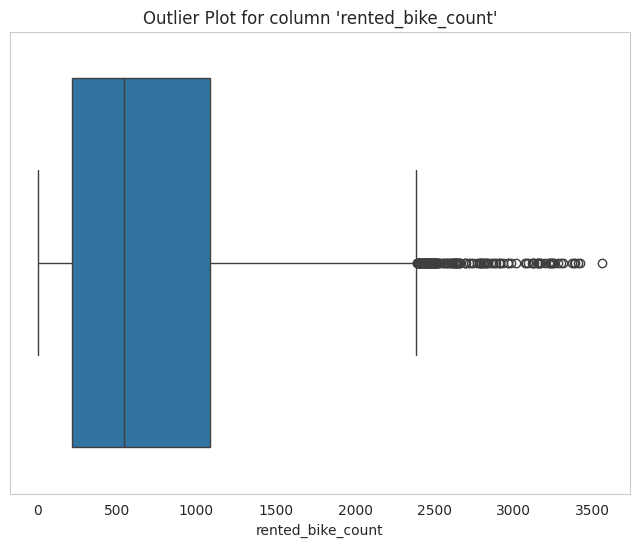

***************************************************************************

No outliers in column 'hour'.
***************************************************************************

No outliers in column 'temperature'.
***************************************************************************

No outliers in column 'humidity'.
***************************************************************************

Outliers in column 'wind_speed':
Outlier Count: 139
Outlier Percentage of total observations: 1.64%
Outlier Values: 4.5, 4.8, 5.4, 4.5, 5.8, 4.7, 5.3, 4.5, 4.5, 4.7, 5.1, 4.5, 4.6, 5.1, 4.5, 5.0, 4.9, 4.7, 5.0, 4.7, 4.5, 6.7, 4.6, 4.6, 5.0, 4.5, 4.6, 4.5, 4.5, 4.7, 5.3, 4.8, 4.5, 4.5, 4.6, 6.0, 4.7, 5.2, 4.6, 4.5, 4.5, 4.8, 4.6, 4.6, 4.8, 4.9, 4.7, 4.6, 4.5, 4.7, 4.5, 4.9, 5.0, 5.6, 5.1, 5.8, 4.5, 5.3, 4.6, 5.0, 4.9, 5.3, 4.6, 4.7, 6.0, 4.5, 4.8, 5.2, 4.7, 4.7, 4.7, 4.5, 4.6, 5.3, 4.6, 4.9, 4.9, 4.9, 4.8, 4.5, 4.7, 5.0, 4.7, 5.3, 4.6, 5.1, 7.4, 4.8, 5.8, 5.6, 7.2, 5.8, 6.1, 7.3, 5.4, 

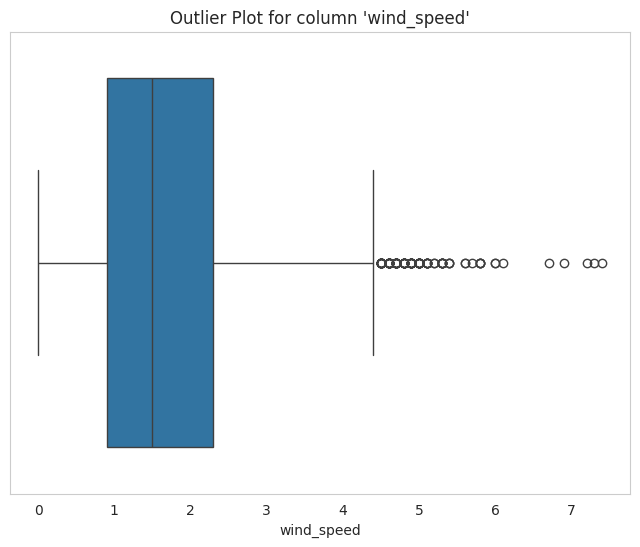

***************************************************************************

No outliers in column 'visibility'.
***************************************************************************

No outliers in column 'dew_point_temperature'.
***************************************************************************

Outliers in column 'solar_radiation':
Outlier Count: 620
Outlier Percentage of total observations: 7.32%
Outlier Values: 2.35, 2.46, 2.39, 2.49, 2.36, 2.5, 2.52, 2.35, 2.48, 2.43, 2.49, 2.95, 2.86, 2.54, 2.61, 2.83, 2.74, 2.48, 2.56, 2.75, 2.66, 2.33, 2.46, 2.45, 2.55, 2.65, 2.47, 2.66, 2.53, 2.47, 2.67, 2.69, 2.34, 2.44, 2.6, 2.43, 2.66, 2.49, 2.38, 2.78, 2.99, 2.91, 2.62, 2.51, 2.52, 2.36, 2.59, 2.33, 2.7, 2.91, 2.82, 2.51, 2.72, 2.87, 2.71, 2.41, 2.48, 2.42, 2.63, 2.75, 2.62, 2.65, 2.8, 2.7, 2.44, 2.54, 2.37, 2.73, 2.87, 2.75, 2.4, 2.41, 2.53, 2.57, 2.83, 3.24, 3.04, 2.79, 2.98, 2.99, 2.49, 2.93, 3.06, 2.99, 2.6, 2.59, 2.94, 2.77, 2.68, 3.07, 3.2, 3.13, 2.86, 2.39, 2.52, 2.7

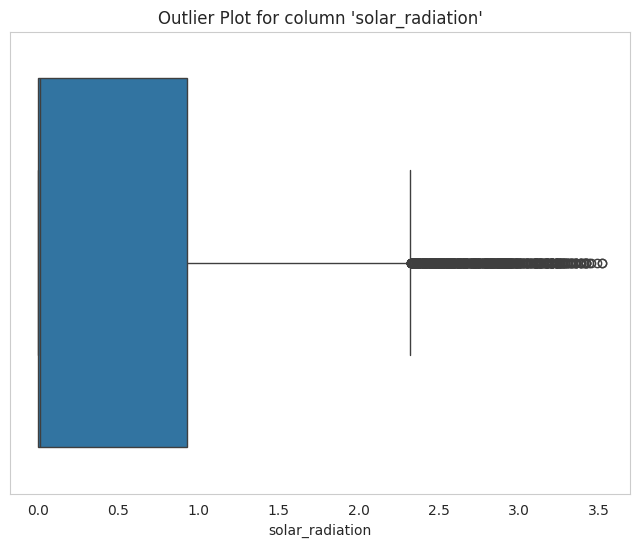

***************************************************************************

Outliers in column 'rainfall':
Outlier Count: 516
Outlier Percentage of total observations: 6.10%
Outlier Values: 0.5, 1.0, 2.5, 0.1, 0.1, 0.2, 0.3, 0.7, 2.5, 1.6, 0.3, 0.4, 1.6, 1.1, 0.1, 0.1, 0.1, 6.4, 9.5, 3.5, 0.5, 0.3, 0.2, 0.2, 1.0, 0.9, 0.5, 0.3, 0.2, 0.2, 0.2, 3.3, 1.4, 1.5, 0.1, 0.4, 0.4, 3.7, 4.5, 9.5, 9.0, 2.0, 0.1, 0.4, 0.1, 0.2, 0.2, 2.0, 9.0, 1.5, 2.0, 0.5, 2.0, 1.5, 0.5, 8.0, 17.0, 2.0, 0.5, 0.3, 0.2, 0.5, 0.5, 0.5, 0.1, 3.5, 7.0, 3.0, 3.0, 2.0, 0.1, 0.4, 1.5, 2.0, 0.5, 0.5, 1.0, 1.0, 1.5, 1.0, 0.5, 0.5, 0.5, 1.5, 2.0, 2.0, 0.5, 0.1, 0.1, 0.1, 1.9, 1.0, 0.5, 1.5, 3.0, 0.2, 0.8, 1.0, 2.0, 1.0, 1.5, 1.5, 0.5, 0.5, 0.3, 0.2, 1.0, 0.5, 0.5, 1.5, 2.5, 4.0, 3.0, 2.0, 0.1, 0.9, 0.5, 3.5, 2.5, 7.0, 6.0, 5.0, 8.0, 4.0, 1.5, 5.5, 2.5, 4.0, 1.5, 1.0, 0.5, 1.0, 1.5, 1.0, 1.5, 0.1, 2.4, 0.5, 0.4, 0.1, 1.0, 3.5, 4.0, 0.5, 0.5, 1.0, 1.0, 0.1, 0.4, 0.5, 0.5, 1.5, 1.5, 2.0, 3.0, 2.5, 2.0, 1.0, 1.5, 3.5, 3.0, 0.4

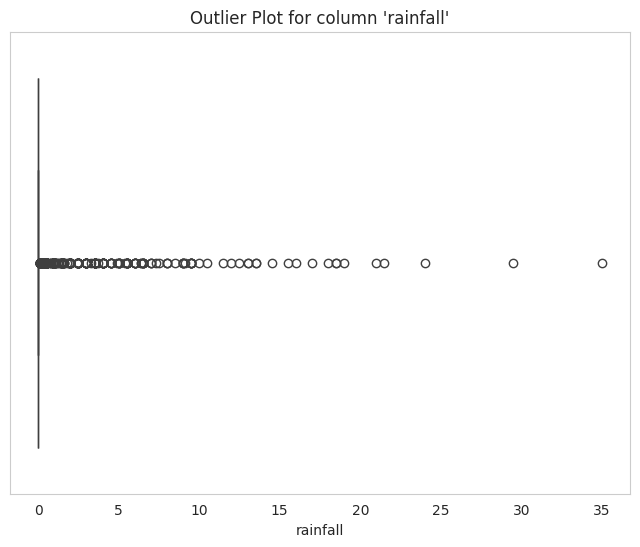

***************************************************************************

Outliers in column 'snowfall':
Outlier Count: 443
Outlier Percentage of total observations: 5.23%
Outlier Values: 0.1, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.2, 0.2, 0.2, 0.3, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.7, 0.6, 0.3, 0.7, 2.7, 4.0, 4.1, 4.3, 4.3, 3.9, 3.1, 2.1, 1.4, 1.0, 0.5, 0.4, 0.2, 0.5, 0.7, 0.8, 1.3, 1.8, 2.0, 4.0, 4.8, 4.8, 5.1, 5.0, 4.2, 3.2, 2.7, 2.7, 2.7, 2.7, 2.7, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.5, 2.5, 2.5, 2.5, 2.3, 2.2, 2.2, 2.1, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.9, 1.9, 1.7, 1.7, 1.6, 1.6, 2.2, 2.2, 2.2, 2.4, 2.4, 2.3, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.1, 2.0, 1.9, 1.8, 1.6, 1.0, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.5, 0.2, 0.6, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.0, 0.7,

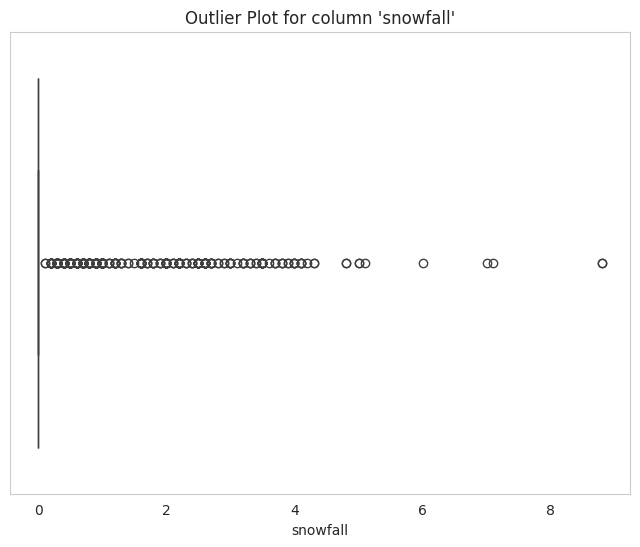

***************************************************************************

No outliers in column 'date_monday' as it has binary values.
***************************************************************************

No outliers in column 'date_saturday' as it has binary values.
***************************************************************************

No outliers in column 'date_sunday' as it has binary values.
***************************************************************************

No outliers in column 'date_thursday' as it has binary values.
***************************************************************************

No outliers in column 'date_tuesday' as it has binary values.
***************************************************************************

No outliers in column 'date_wednesday' as it has binary values.
***************************************************************************

No outliers in column 'seasons_spring' as it has binary values.
***********************

Column Outlier Count Outlier Percentage
0       rented_bike_count           152           1.795629
1                    hour             0                0.0
2             temperature             0                0.0
3                humidity             0                0.0
4              wind_speed           139           1.642056
5              visibility             0                0.0
6   dew_point_temperature             0                0.0
7         solar_radiation           620           7.324276
8                rainfall           516           6.095688
9                snowfall           443           5.233314
10            date_monday           NaN                NaN
11          date_saturday           NaN                NaN
12            date_sunday           NaN                NaN
13          date_thursday           NaN                NaN
14           date_tuesday           NaN                NaN
15         date_wednesday           NaN                NaN
16         seasons_spring           NaN                NaN
17         seasons_summer           NaN                NaN
18         seasons_winter           NaN                NaN
19                holiday           NaN                NaN

In [60]:
detect_outliers(df)

1. In the "rented_bike_count" column, there are 152 outliers, which account for approximately 1.8% of the total values in this column. These outliers may indicate unusually high or low demand for bike rentals during certain hours.

2. The "wind_speed" column has 139 outliers, which represent about 1.6% of the data. This suggests the presence of strong winds at certain times, which can influence the demand for bikes.

3. The "solar_radiation" column shows 620 outliers, amounting to around 7.3%. This indicates that some measured values of solar radiation were unusually high or low. These outliers could reflect variations in solar activity.

4. The "rainfall" and "snowfall" columns have 516 and 443 outliers, respectively, accounting for approximately 6.1% and 5.2%. This may indicate weather conditions such as heavy rainfall or snowfall, which can affect bike demand.



---


1. For the "rented_bike_count" column, further analysis of these outliers is needed to determine the reasons behind their occurrence. Understanding the factors contributing to the highest impact on bike rental demand can be valuable information.

2. Conducting analysis on the outliers in the "wind_speed", "solar_radiation", "rainfall", and "snowfall" columns, and exploring their relationship with other factors such as temperature, humidity, and visibility can help identify the weather conditions that have the most significant impact on bike demand.

3. If the features"solar_radiation", "rainfall" and "snowfall" have a big impact on the target feature in correlation,  the outliers must be accounted for when making predictions for bike rental demand.

## Data Correlation

### df

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_cou

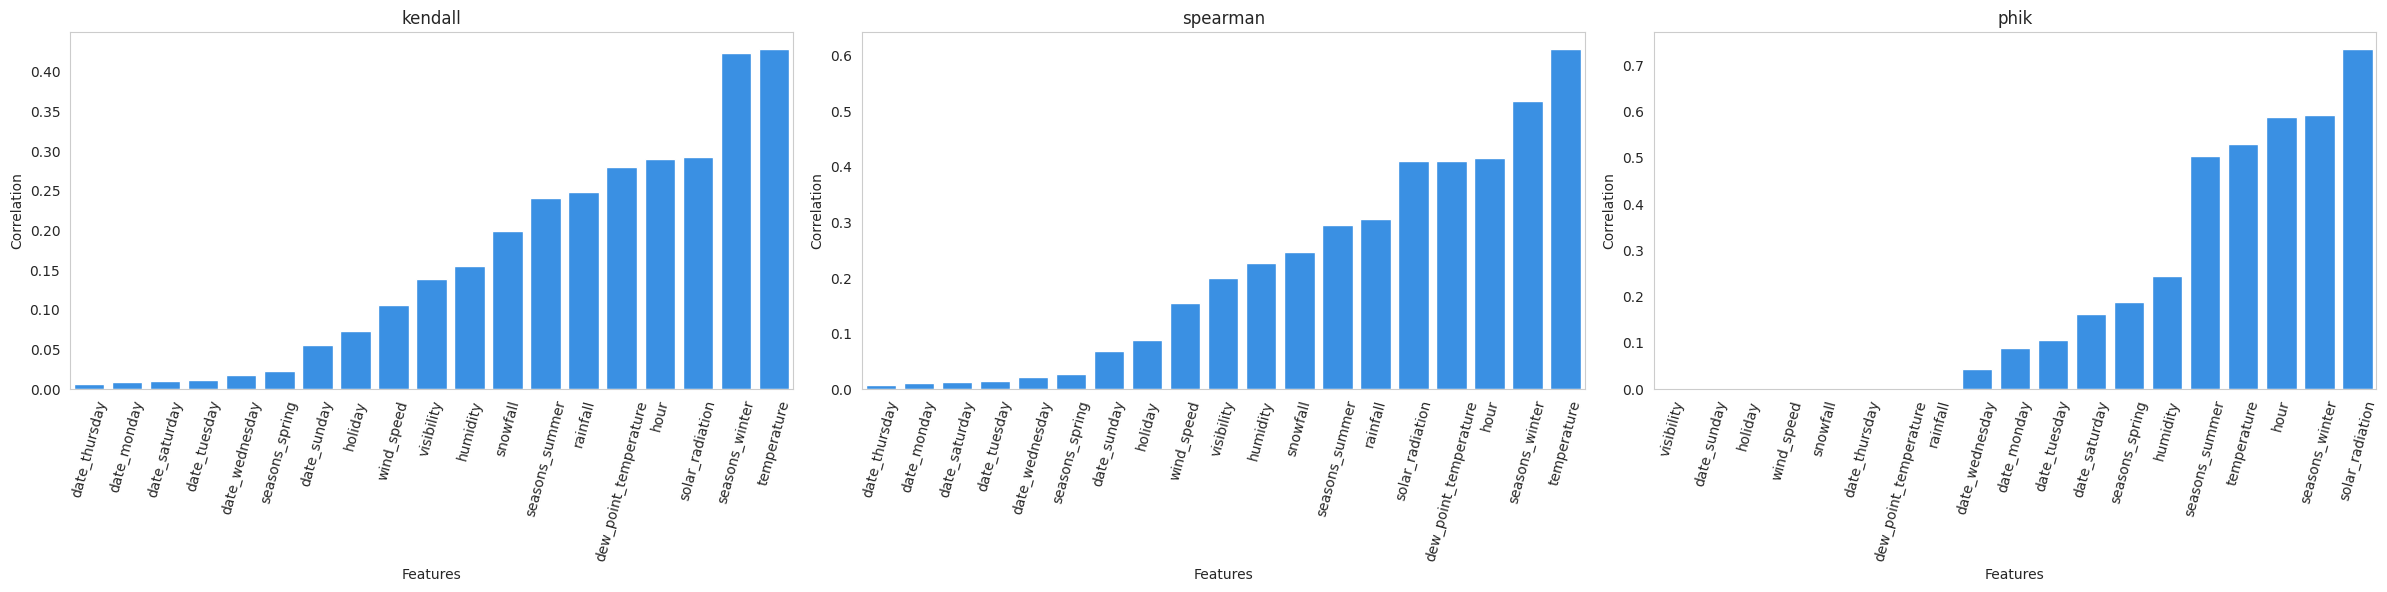

Correlation table with target feature 'rented_bike_count':


Correlation Type        kendall  spearman      phik
Column                                             
temperature            0.428539  0.611726  0.529233
seasons_winter         0.423929  0.518999  0.592327
solar_radiation        0.293117  0.409508  0.734394
hour                   0.289395  0.414948  0.588059
dew_point_temperature  0.279408  0.410788  0.000000
rainfall               0.248205  0.305837  0.000000
seasons_summer         0.240571  0.294521  0.504399
snowfall               0.199050  0.246787  0.000000
humidity               0.155460  0.226477  0.244931
visibility             0.138523  0.198904  0.000000
wind_speed             0.105914  0.154984  0.000000
holiday                0.072477  0.088731  0.000000
date_sunday            0.055460  0.067898  0.000000
seasons_spring         0.022033  0.026975  0.188488
date_wednesday         0.017916  0.021933  0.043378
date_tuesday           0.011329  0.013870  0.106308
date_saturday          0.009889  0.012106  0.163018
date_monday            0.008263  0.010116  0.088152
date_thursday          0.005769  0.007063  0.000000


Top 2 features with highest correlation (Kendall): ['temperature', 'seasons_winter']

Top 2 features with highest correlation (Spearman): ['temperature', 'seasons_winter']

Top 2 features with highest correlation (Phik): ['solar_radiation', 'seasons_winter']


In [81]:
# Take a look at Spearman, Kendell and Phi_k correlations with the target variable in df

correlation_analysis(df, 'rented_bike_count', correlation_types=['kendall', 'spearman', 'phik'], apply_abs=True)

Выведем мультиколиарные признаки

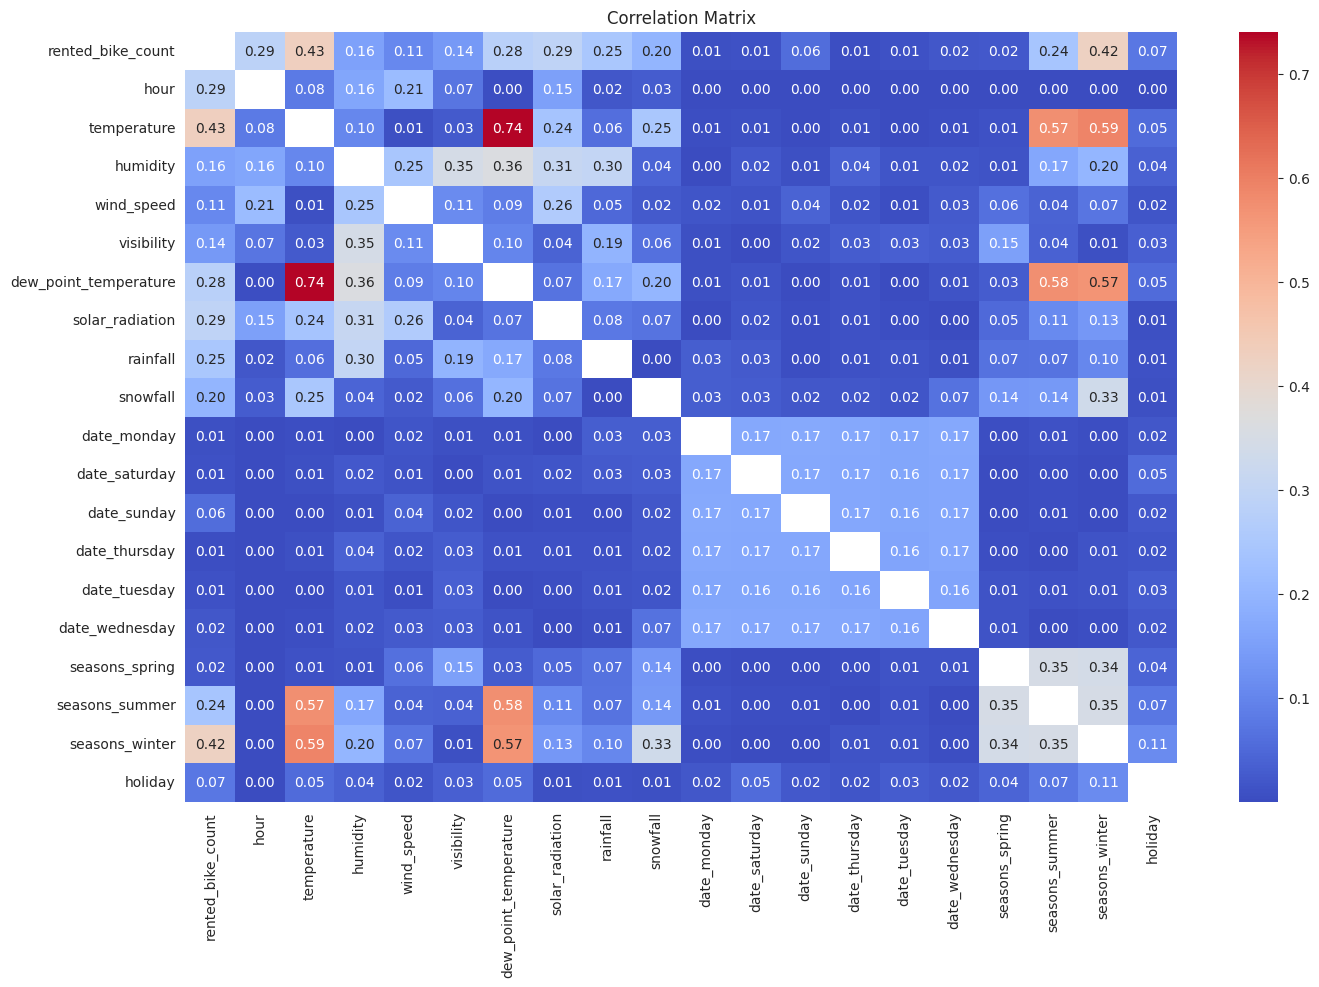

No features with high multicollinearity


In [104]:
find_multicollinearity(df, method='kendall', threshold=0.8)

### df_grouped

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_count is large: 2165. Are you sure this is not an interval variable? Analysis for pairs of variables including rented_bike_count can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable rented_bike_cou

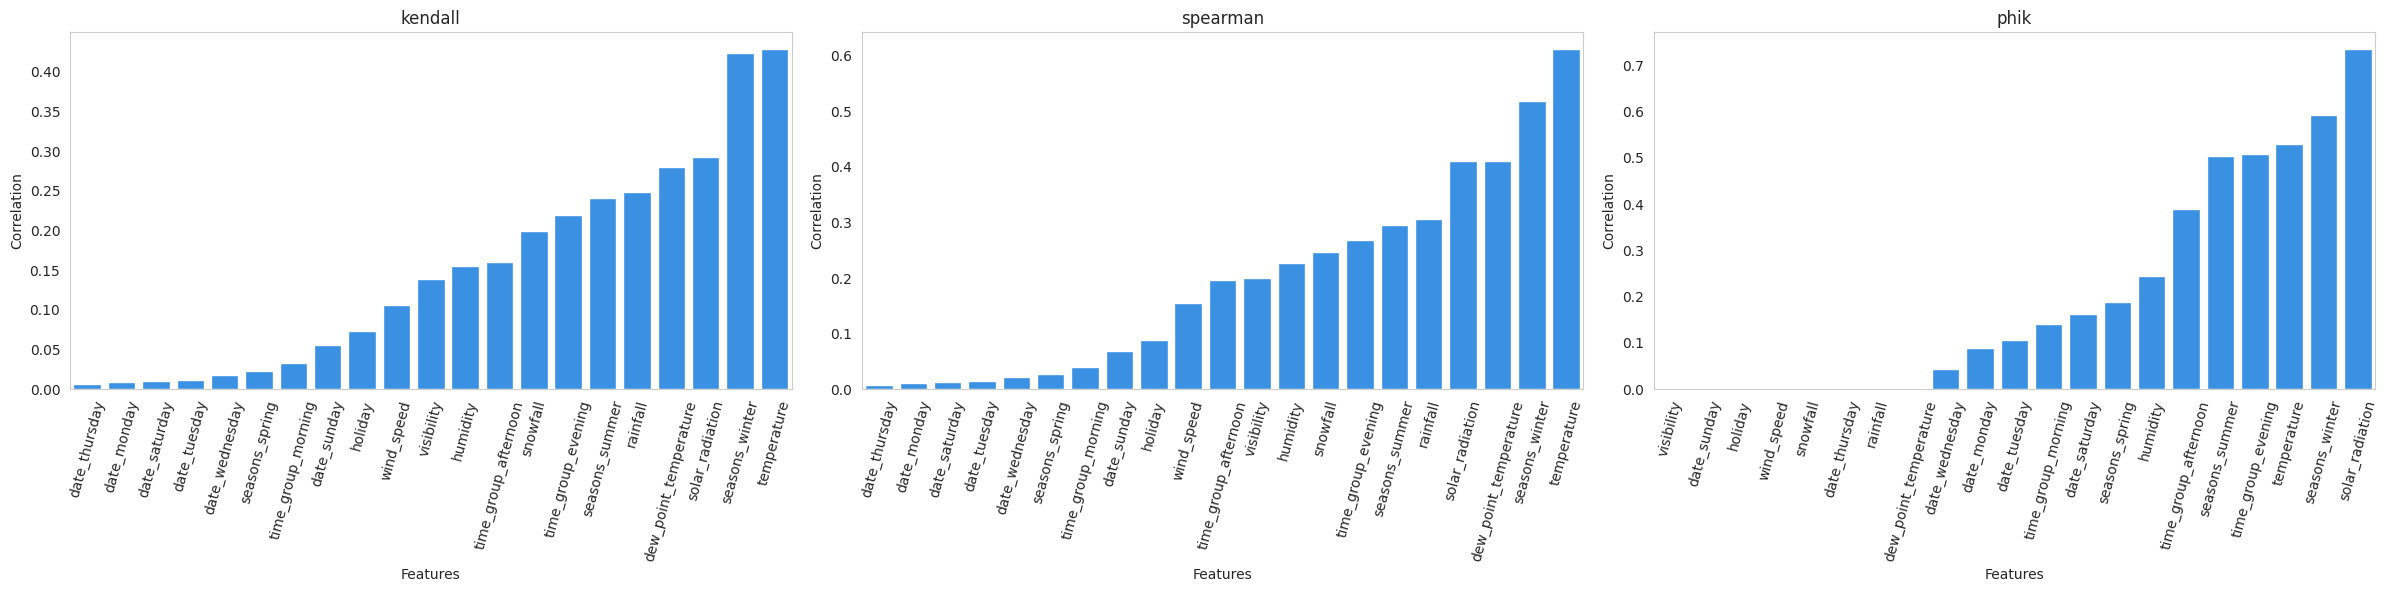

Correlation table with target feature 'rented_bike_count':


Correlation Type        kendall  spearman      phik
Column                                             
temperature            0.428539  0.611726  0.529233
seasons_winter         0.423929  0.518999  0.592327
solar_radiation        0.293117  0.409508  0.734394
dew_point_temperature  0.279408  0.410788  0.000000
rainfall               0.248205  0.305837  0.000000
seasons_summer         0.240571  0.294521  0.504399
time_group_evening     0.218798  0.267866  0.508252
snowfall               0.199050  0.246787  0.000000
time_group_afternoon   0.160452  0.196435  0.388957
humidity               0.155460  0.226477  0.244931
visibility             0.138523  0.198904  0.000000
wind_speed             0.105914  0.154984  0.000000
holiday                0.072477  0.088731  0.000000
date_sunday            0.055460  0.067898  0.000000
time_group_morning     0.032108  0.039309  0.139534
seasons_spring         0.022033  0.026975  0.188488
date_wednesday         0.017916  0.021933  0.043378
date_tuesday           0.011329  0.013870  0.106308
date_saturday          0.009889  0.012106  0.163018
date_monday            0.008263  0.010116  0.088152
date_thursday          0.005769  0.007063  0.000000


Top 2 features with highest correlation (Kendall): ['temperature', 'seasons_winter']

Top 2 features with highest correlation (Spearman): ['temperature', 'seasons_winter']

Top 2 features with highest correlation (Phik): ['solar_radiation', 'seasons_winter']


In [83]:
# Take a look at Spearman, Kendell and Phi_k correlations with the target variable in df_grouped

correlation_analysis(df_grouped, 'rented_bike_count', correlation_types=['kendall', 'spearman', 'phik'], apply_abs=True)

Посмотрим на корреляцию всех признаков между собой

level_0          level_1      phik   pearson   kendall  \
0              temperature(°c)           winter  0.966276  0.740433  0.592178   
1    dew_point_temperature(°c)           summer  0.936662  0.664183  0.575910   
2                       summer  temperature(°c)  0.935591  0.677872  0.574780   
3    dew_point_temperature(°c)           winter  0.933646  0.723221  0.565510   
4    dew_point_temperature(°c)  temperature(°c)  0.892736  0.914467  0.740973   
..                         ...              ...       ...       ...       ...   
226                  afternoon          tuesday  0.000000  0.000189  0.000189   
227                  afternoon           sunday  0.000000  0.000196  0.000196   
228                  afternoon         saturday  0.000000  0.001165  0.001165   
229                  afternoon           monday  0.000000  0.000198  0.000198   
230                    morning           spring  0.000000  0.000120  0.000120   

     spearman  
0    0.724394  
1    0.704503  
2    0.703112  
3    0.691781  
4    0.913720  
..        ...  
226  0.000189  
227  0.000196  
228  0.001165  
229  0.000198  
230  0.000120  

[231 rows x 6 columns]

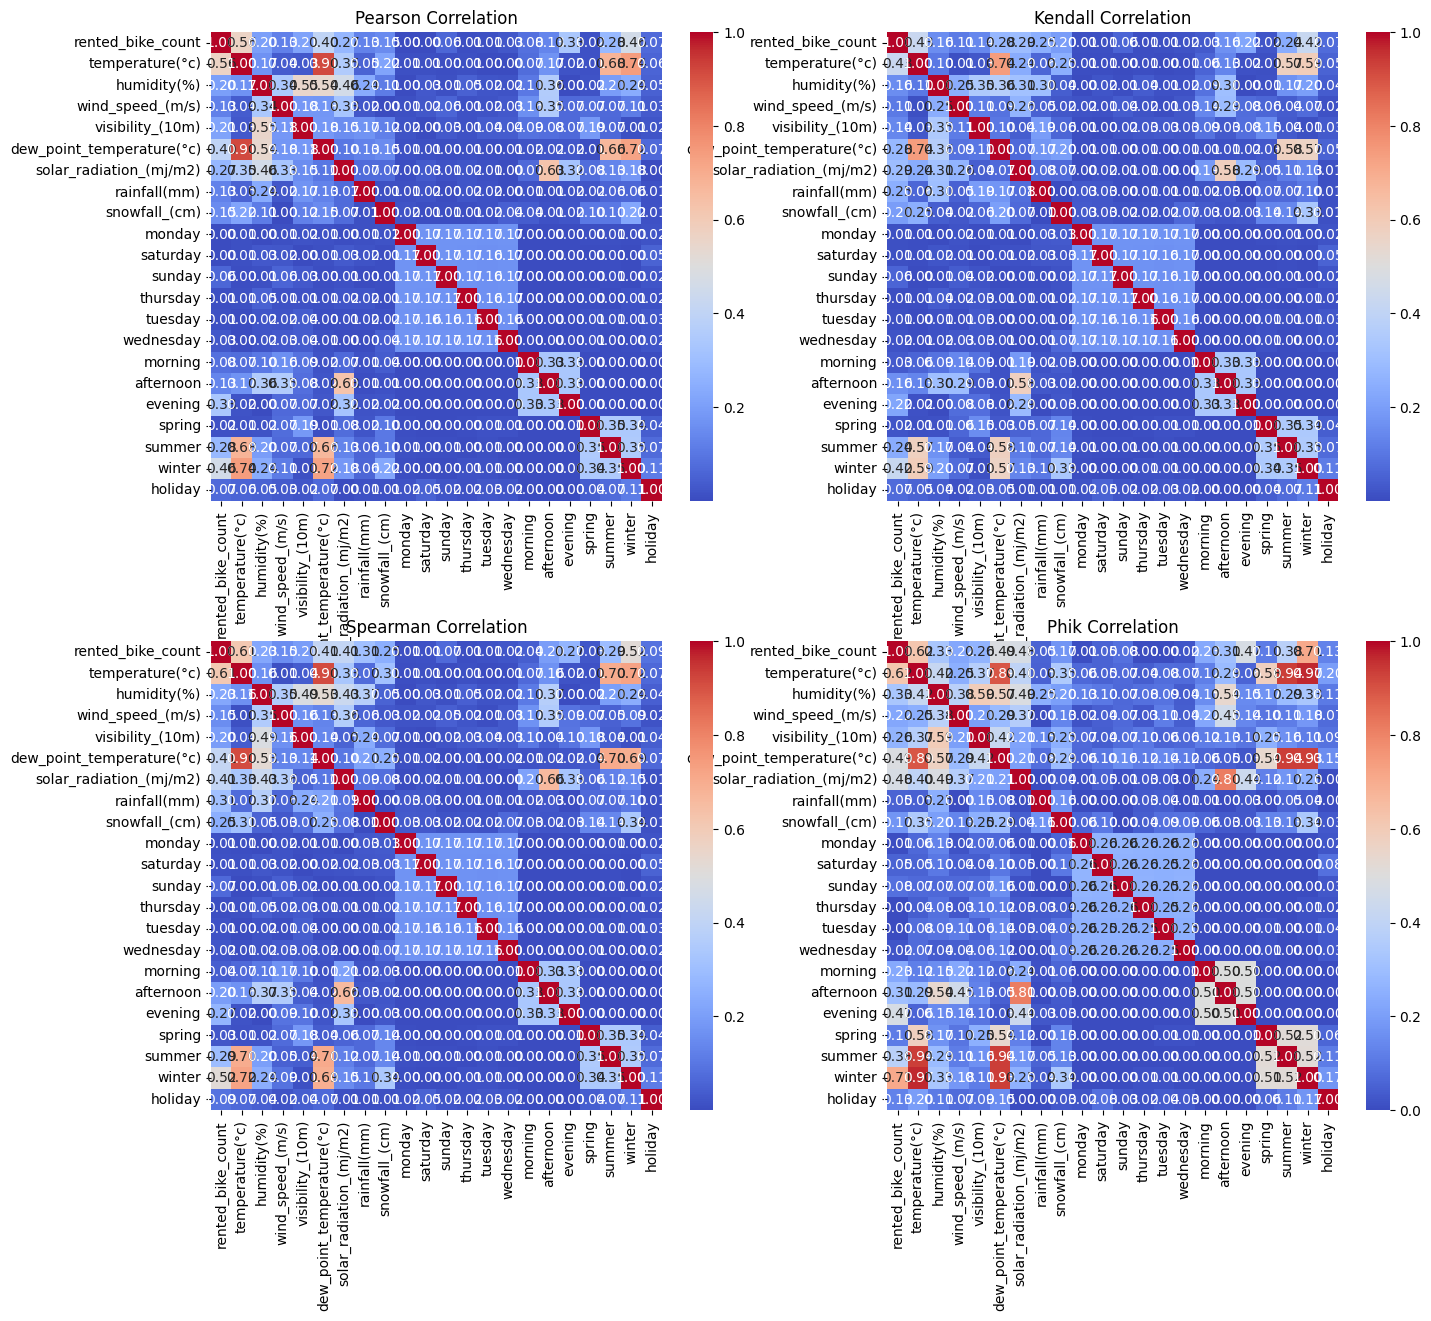

In [ ]:
# Корреляции по всем признакам
correlation_data_full(df_grouped, 'phik', True)

Выведем мультиколиарные признаки

In [ ]:
display(find_multicollinearity(df_grouped, 'phik', threshold=0.7))
display(find_multicollinearity(df_grouped, 'kendall', threshold=0.7))
display(find_multicollinearity(df_grouped, 'spearman', threshold=0.7))

('КОРРЕЛЯЦИЯ PHIK',
 [('rented_bike_count', 'winter'),
  ('temperature(°c)', 'dew_point_temperature(°c)'),
  ('temperature(°c)', 'summer'),
  ('temperature(°c)', 'winter'),
  ('dew_point_temperature(°c)', 'summer'),
  ('dew_point_temperature(°c)', 'winter'),
  ('solar_radiation_(mj/m2)', 'afternoon')])

('КОРРЕЛЯЦИЯ KENDALL', [('temperature(°c)', 'dew_point_temperature(°c)')])

('КОРРЕЛЯЦИЯ SPEARMAN',
 [('temperature(°c)', 'dew_point_temperature(°c)'),
  ('temperature(°c)', 'summer'),
  ('temperature(°c)', 'winter'),
  ('dew_point_temperature(°c)', 'summer')])

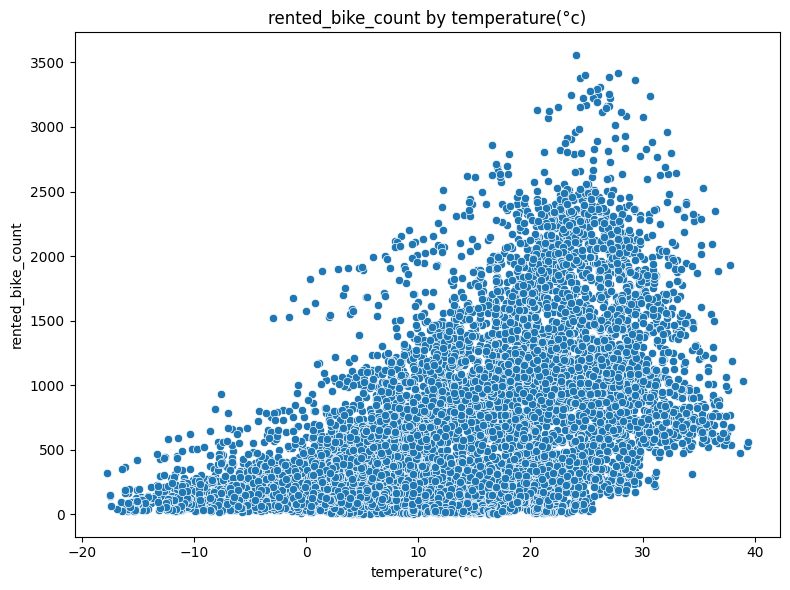

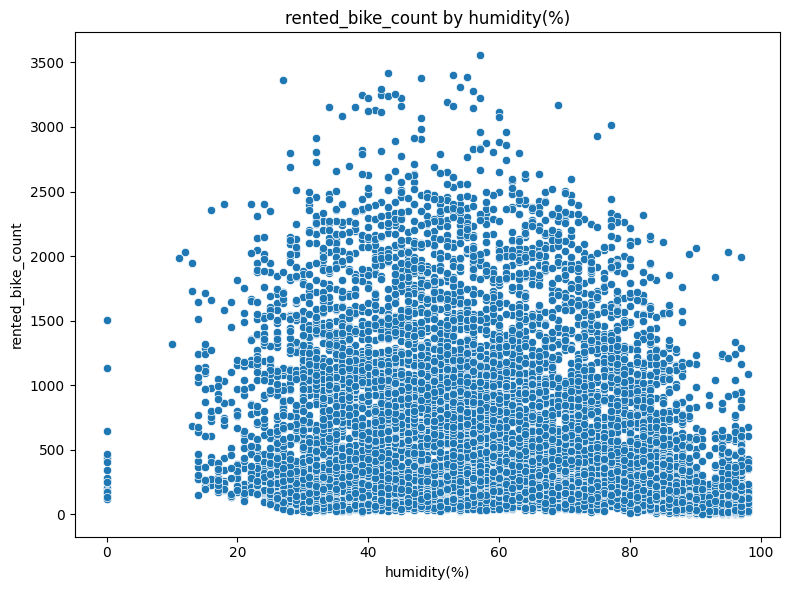

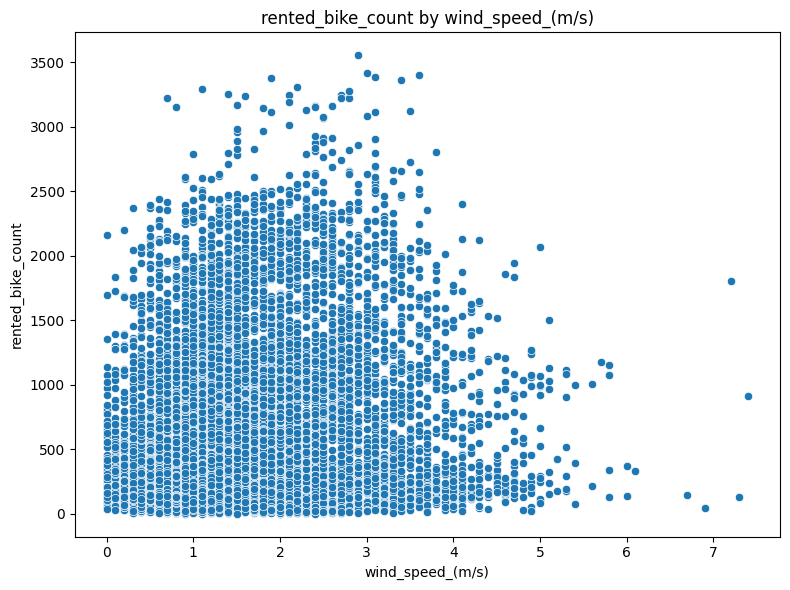

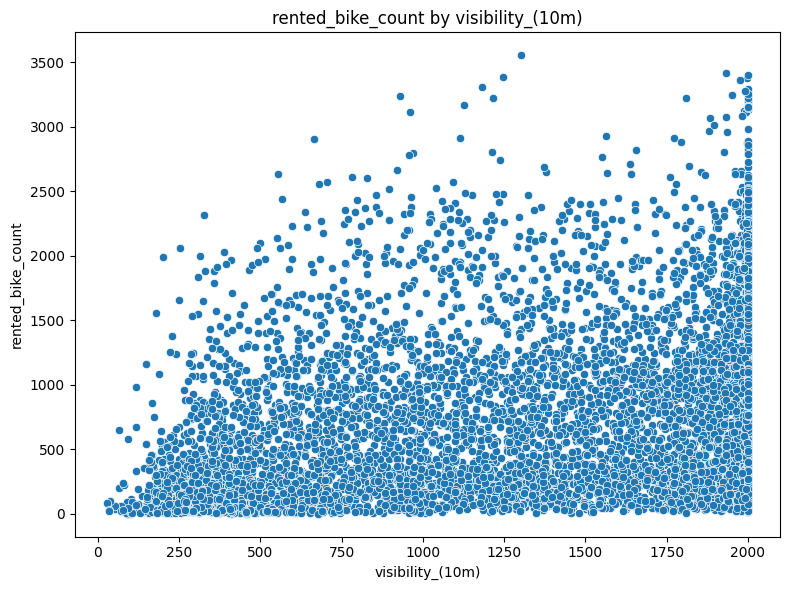

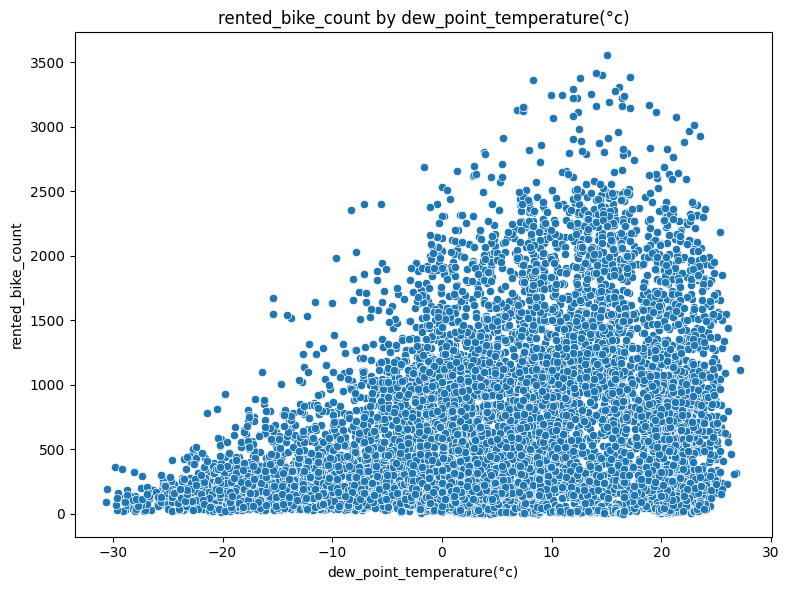

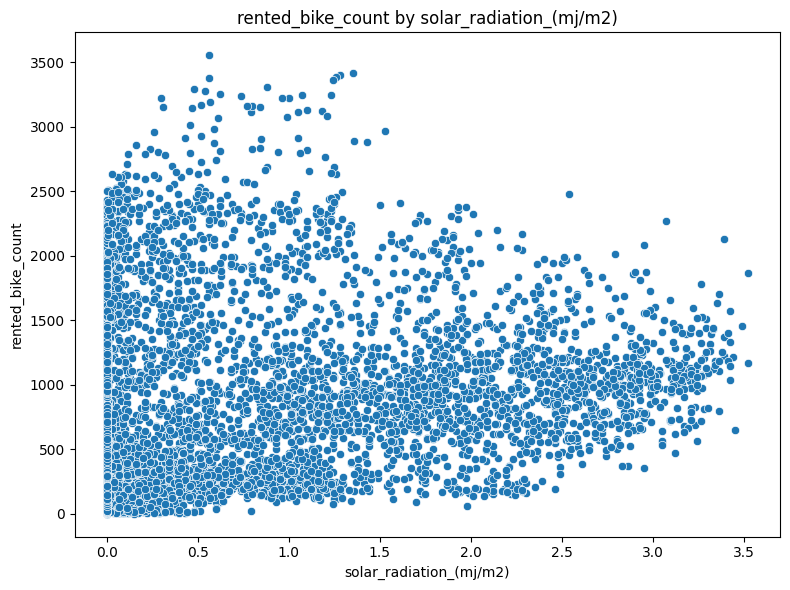

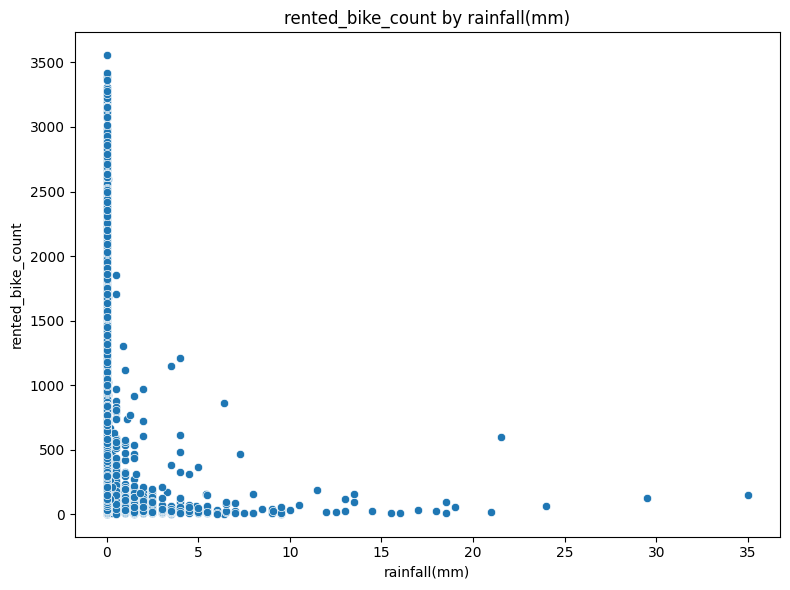

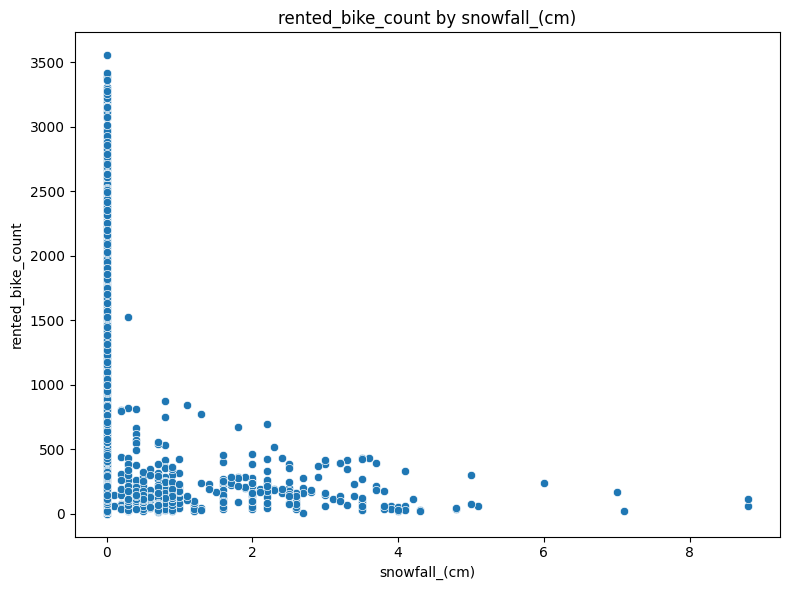

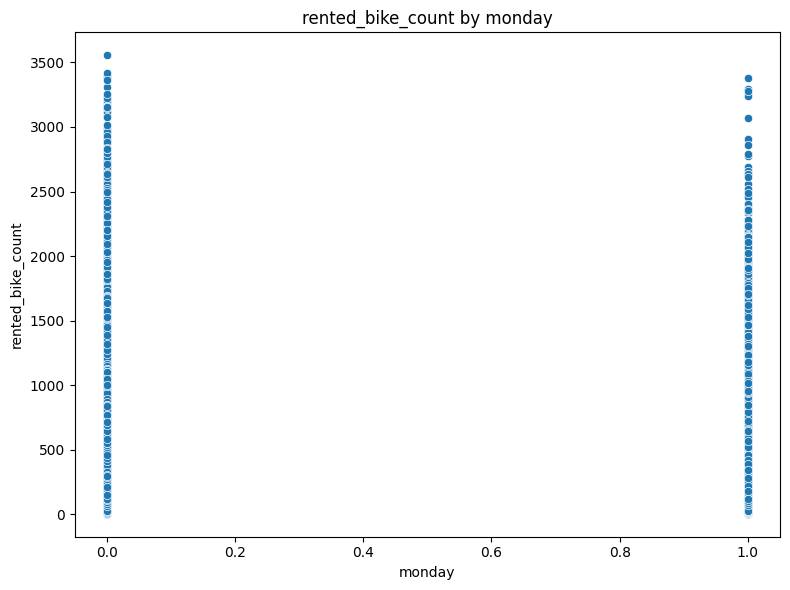

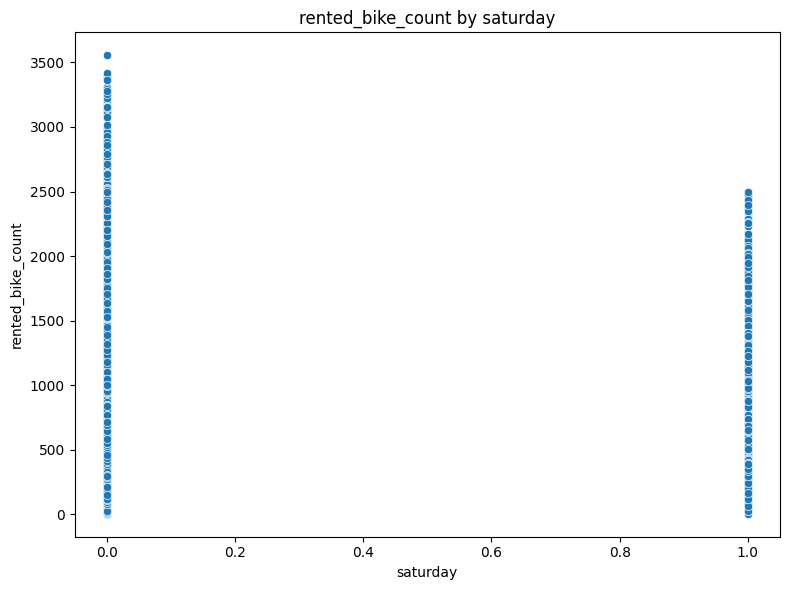

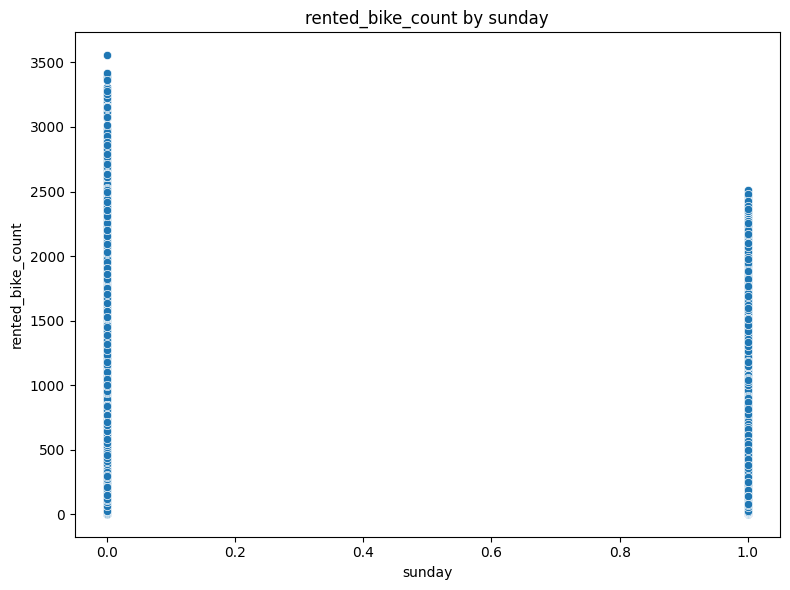

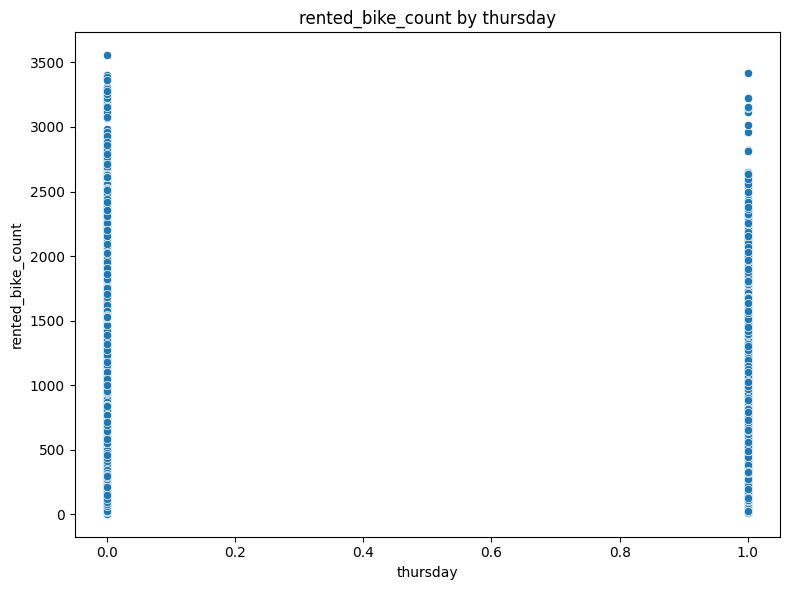

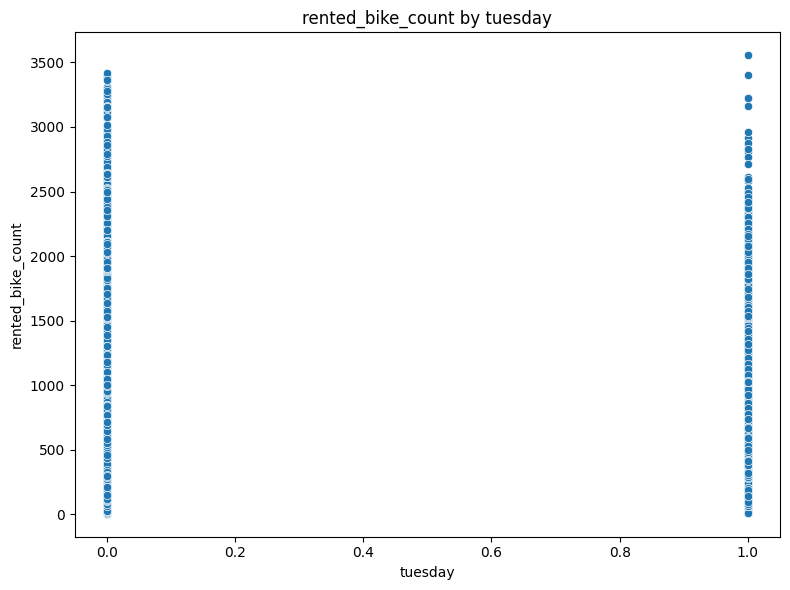

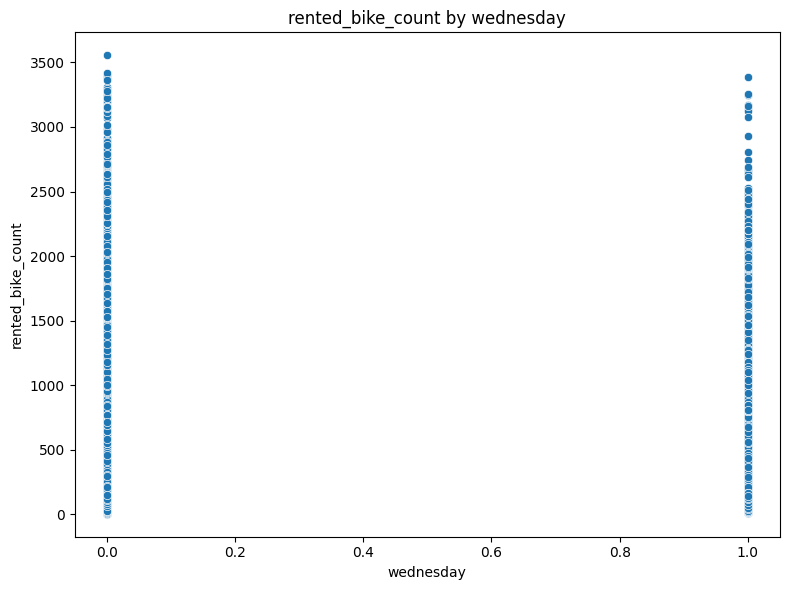

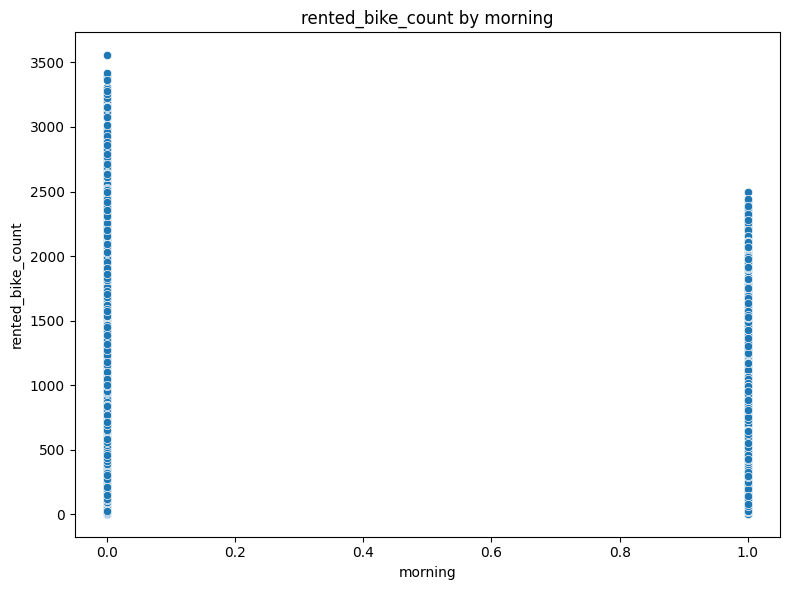

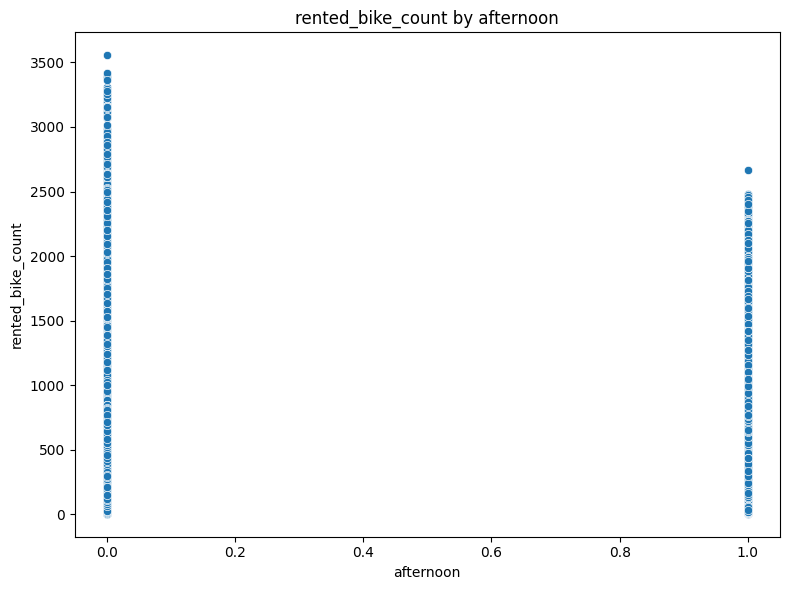

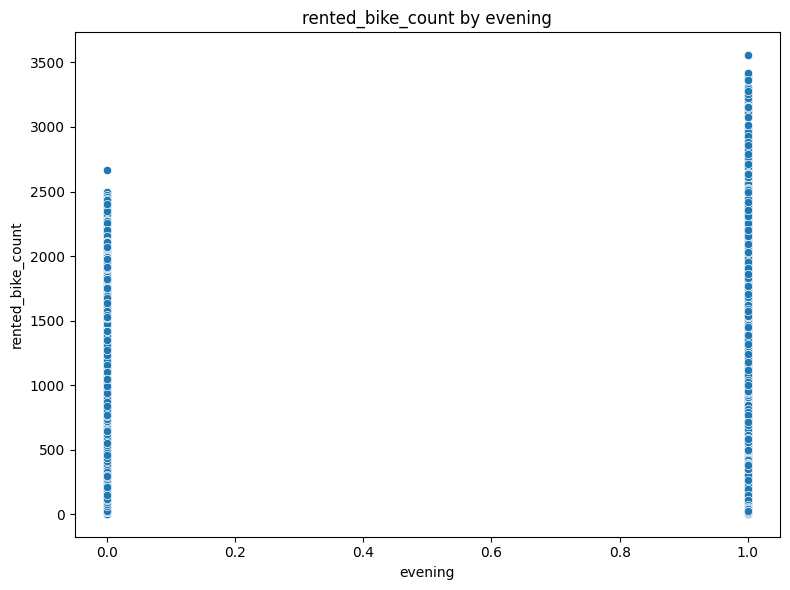

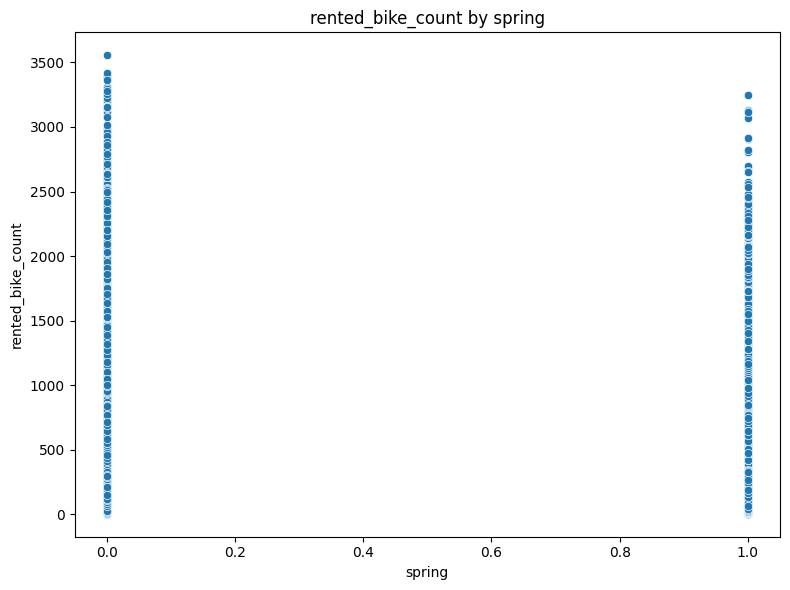

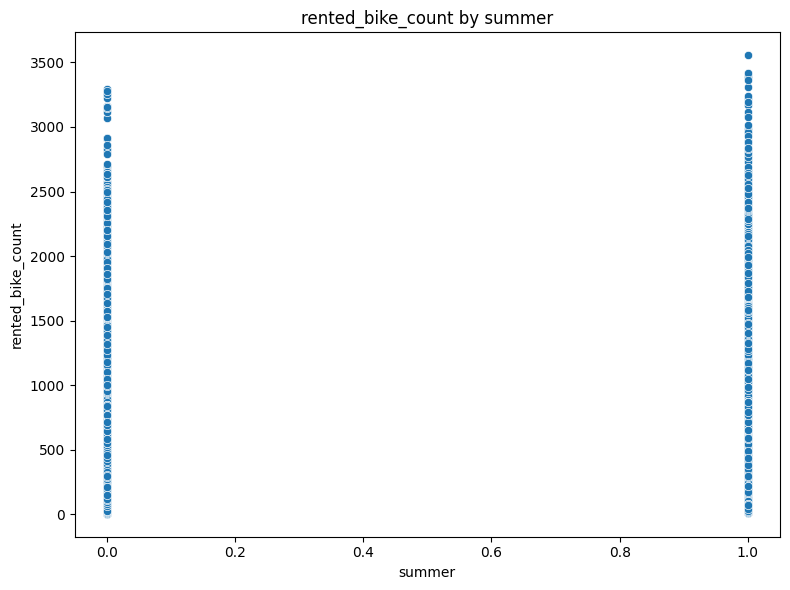

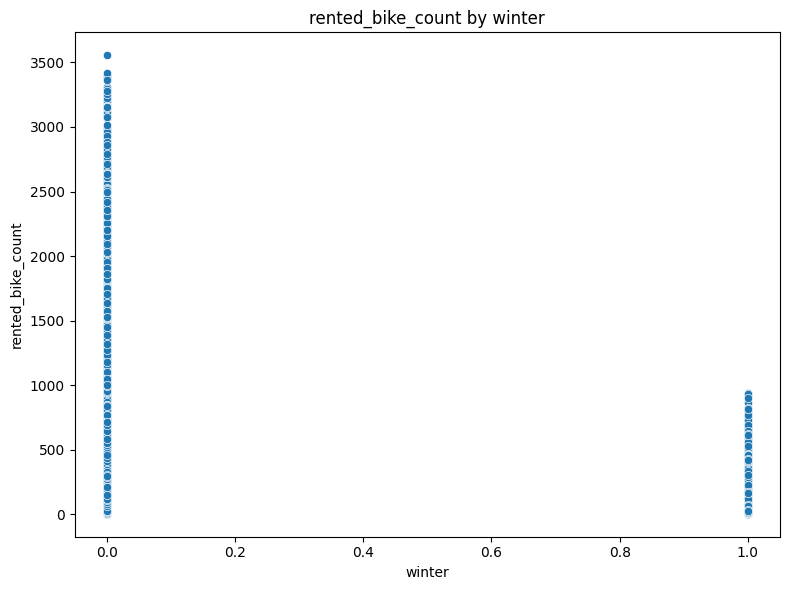

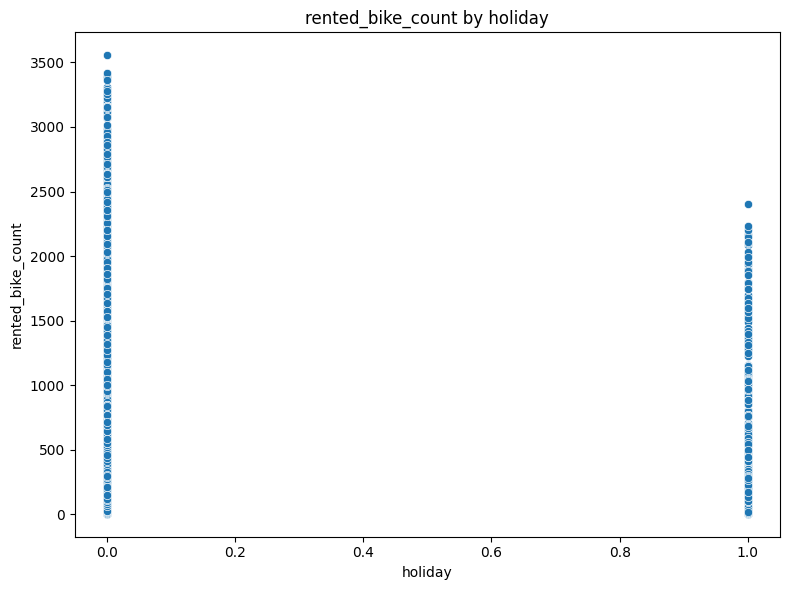

In [ ]:
target_feature_dynamics(df_grouped, 'rented_bike_count')

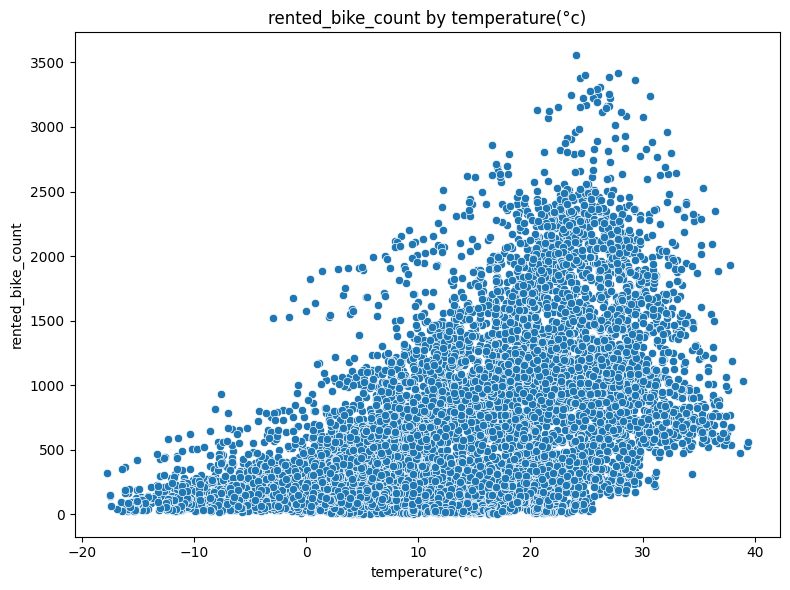

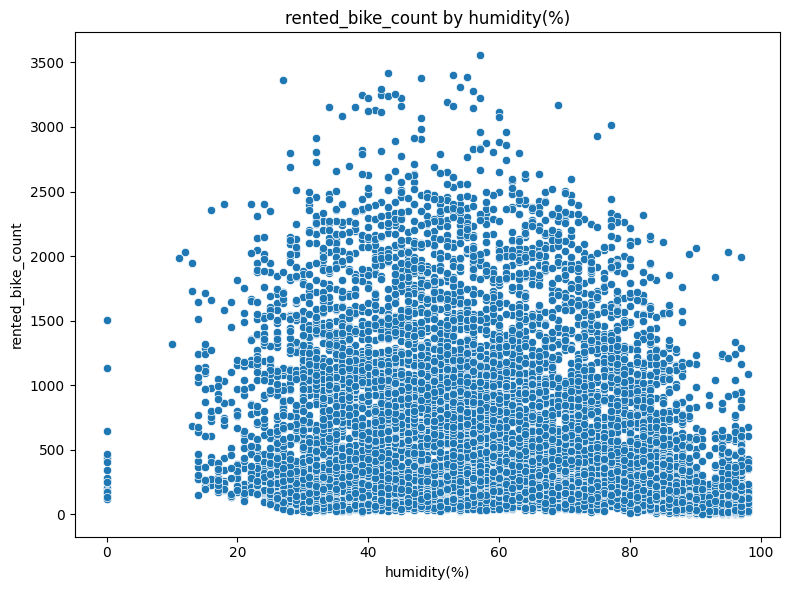

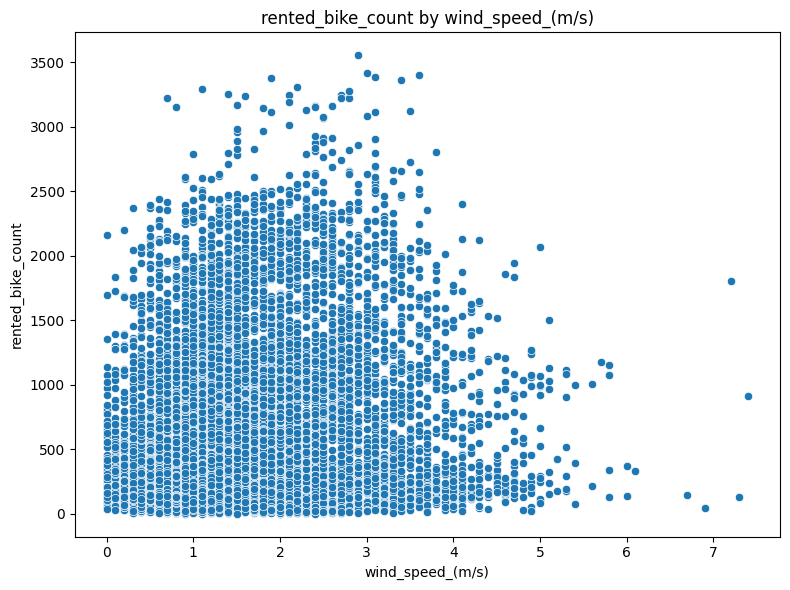

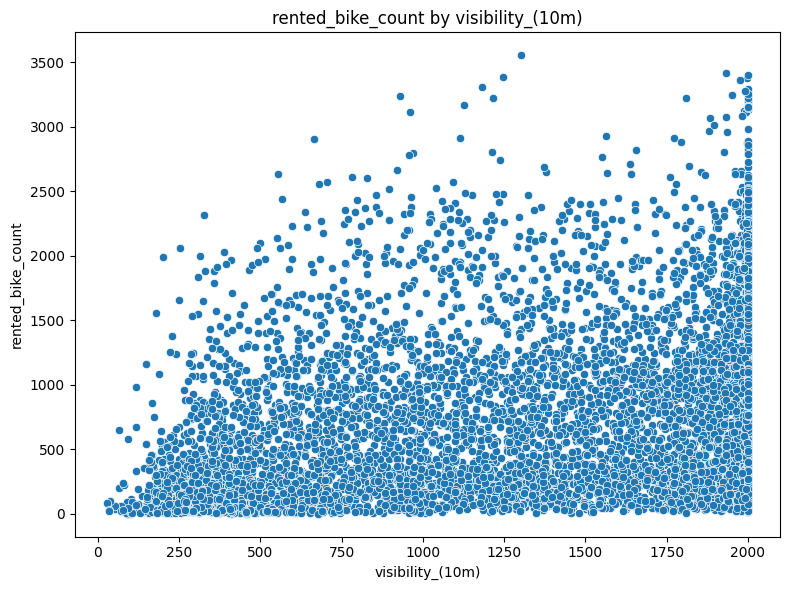

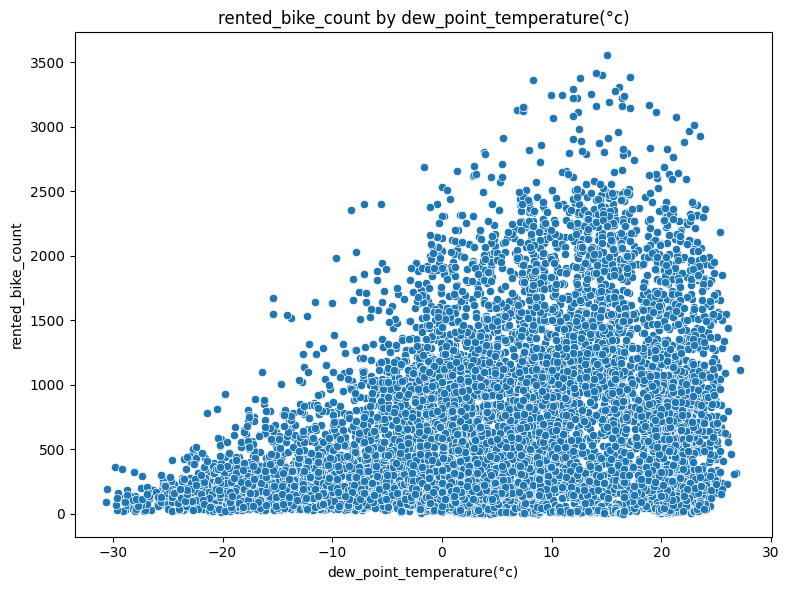

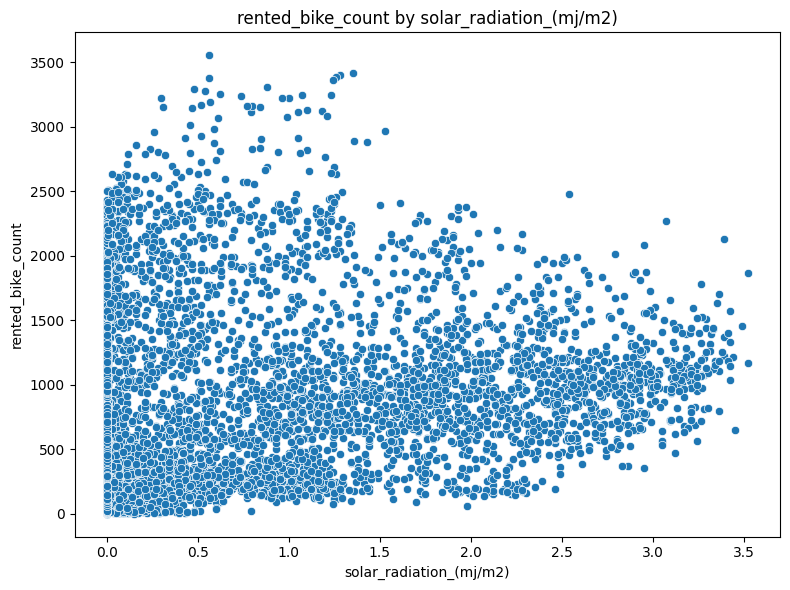

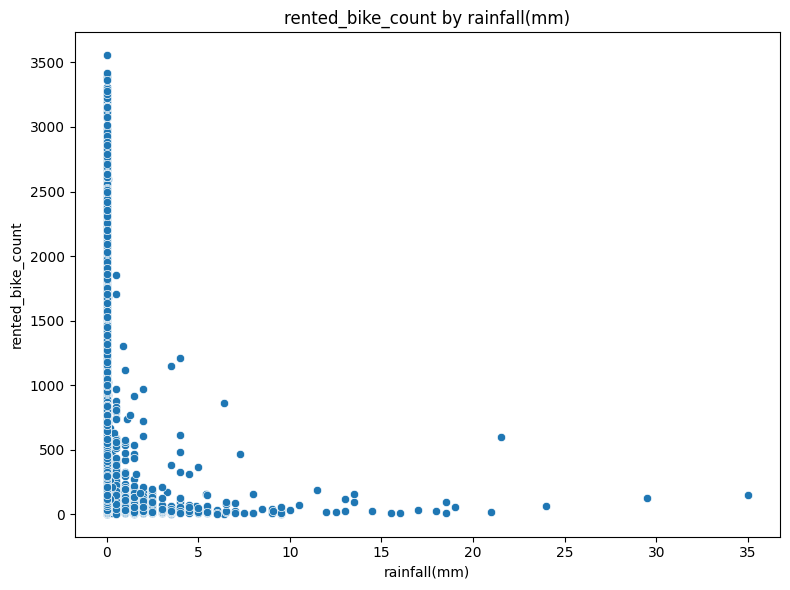

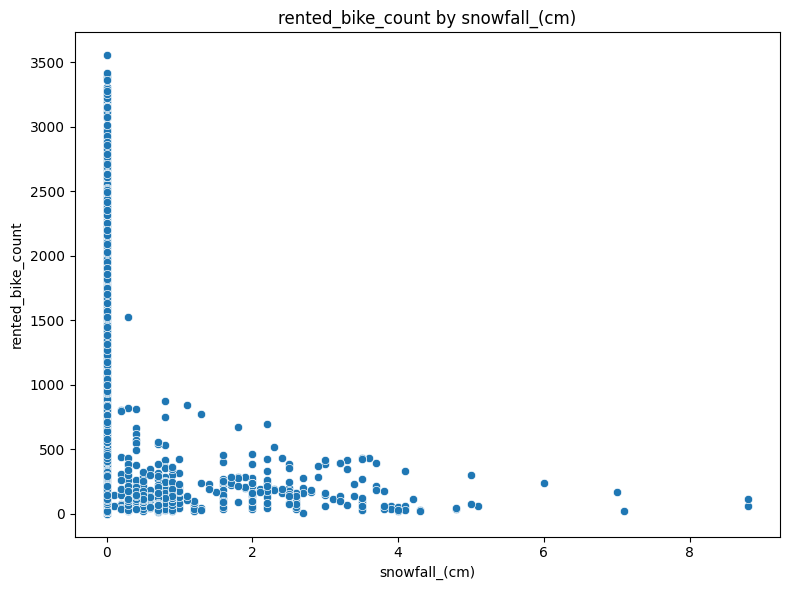

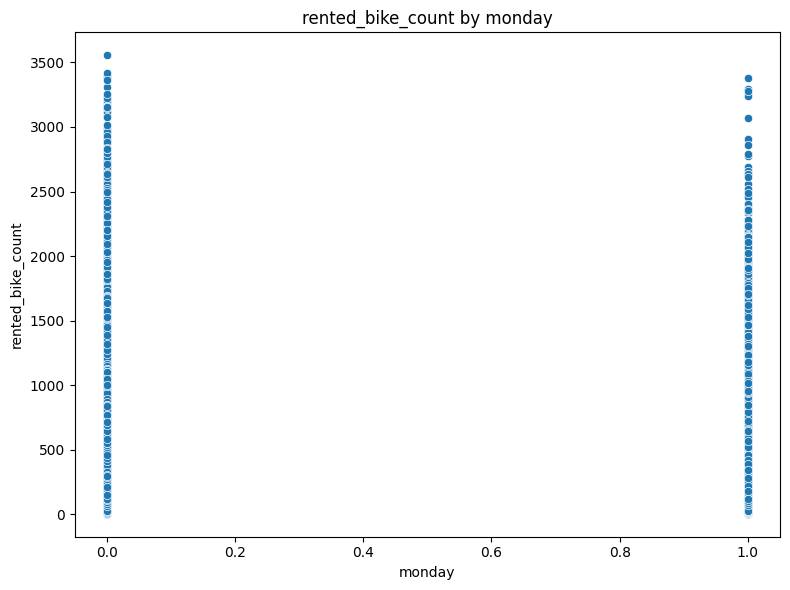

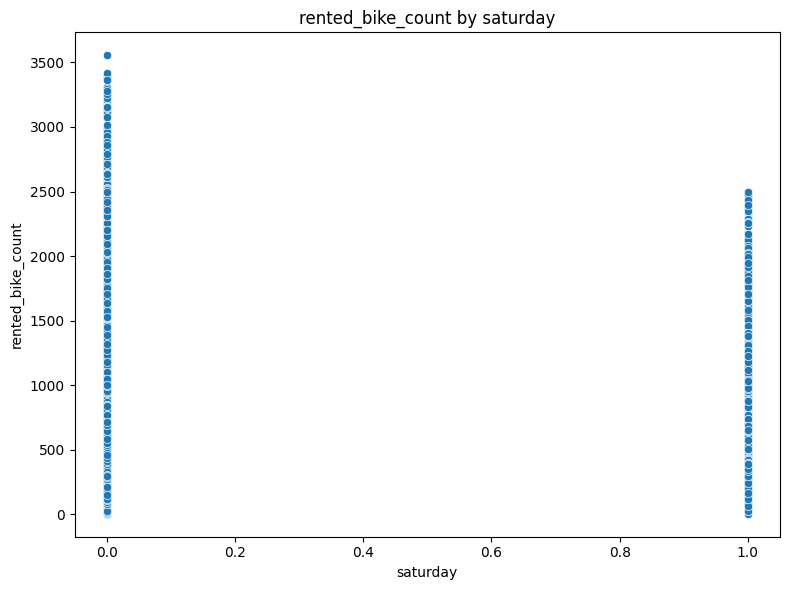

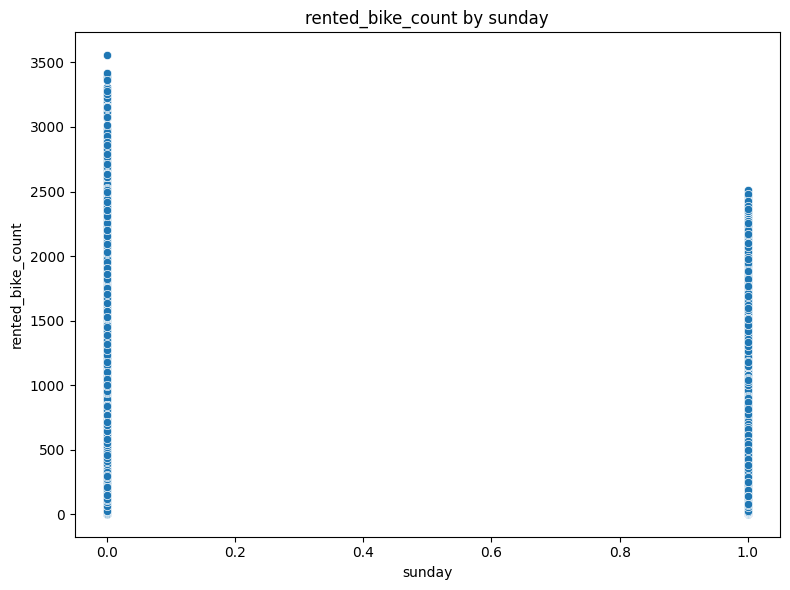

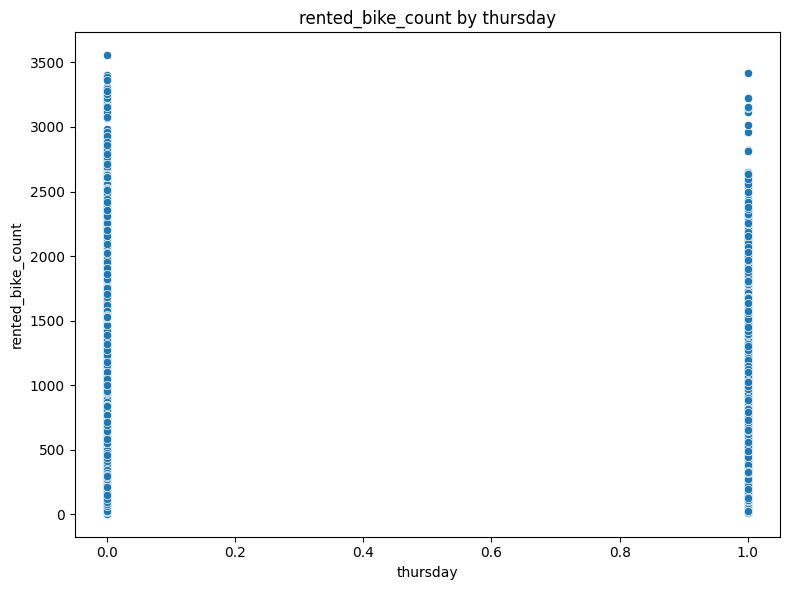

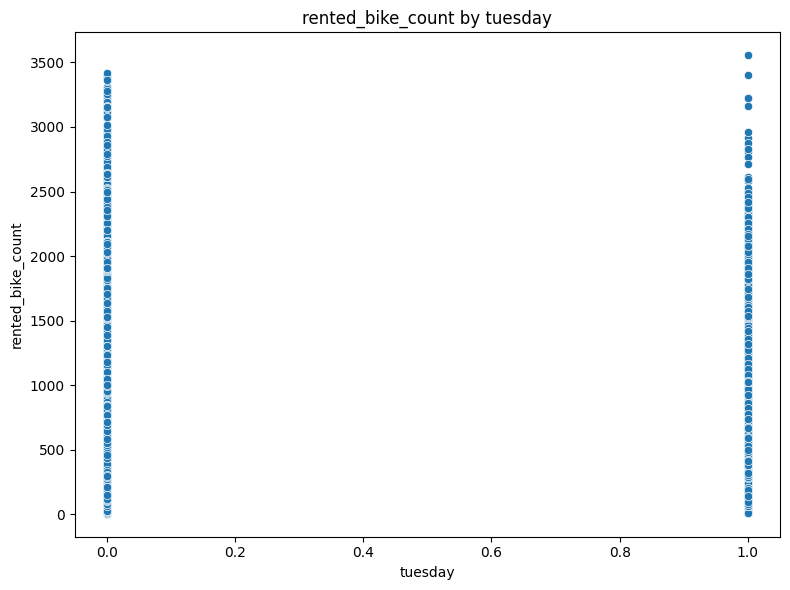

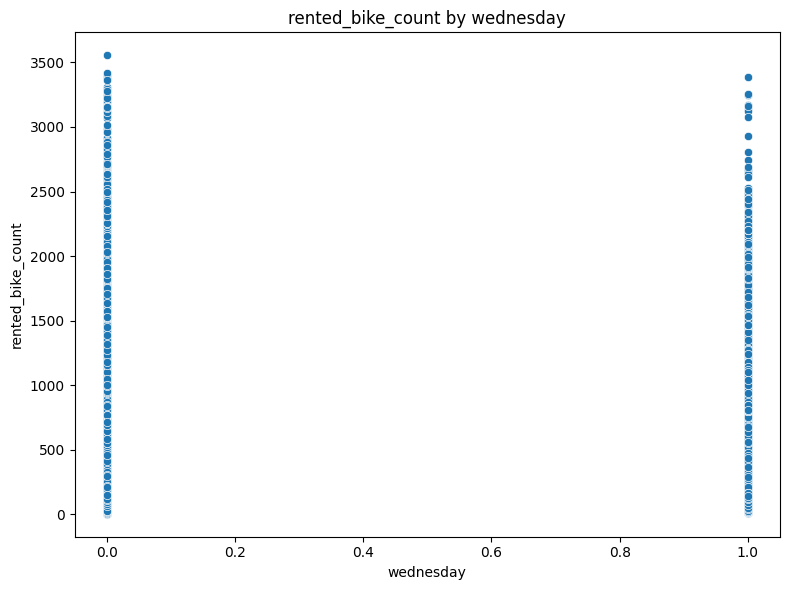

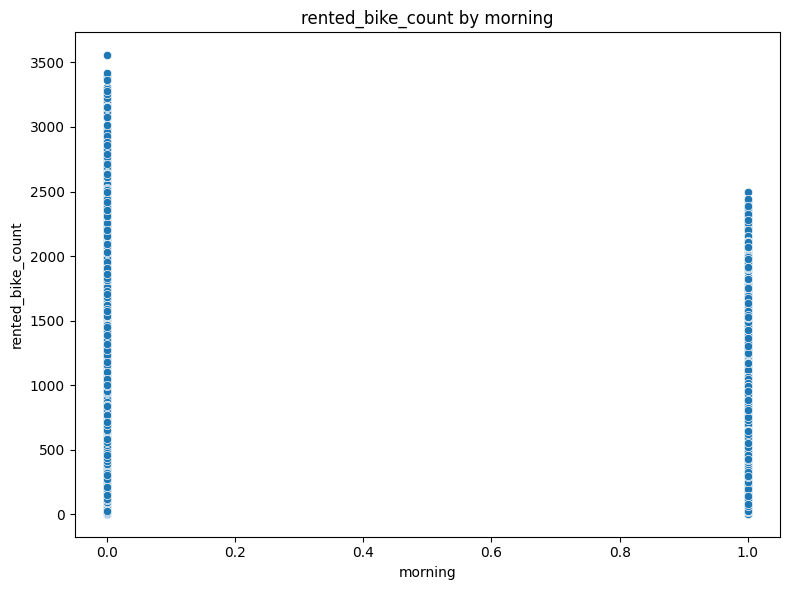

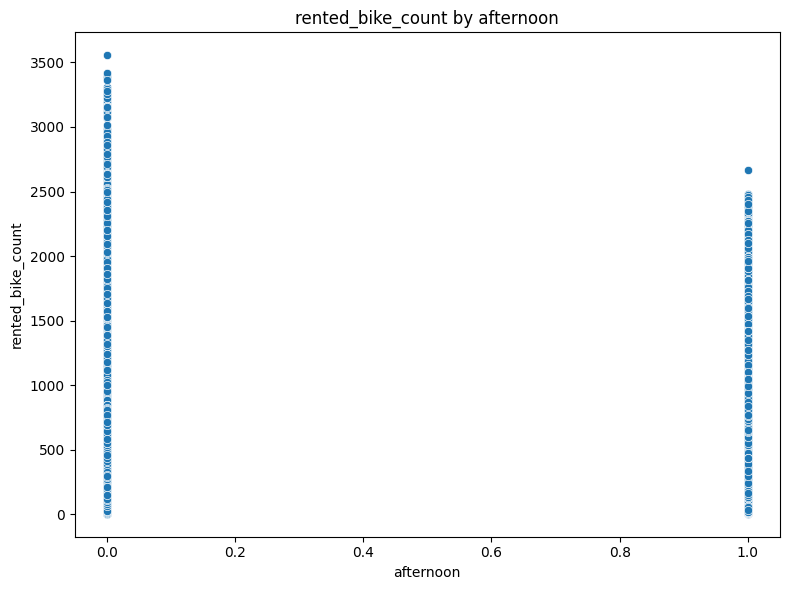

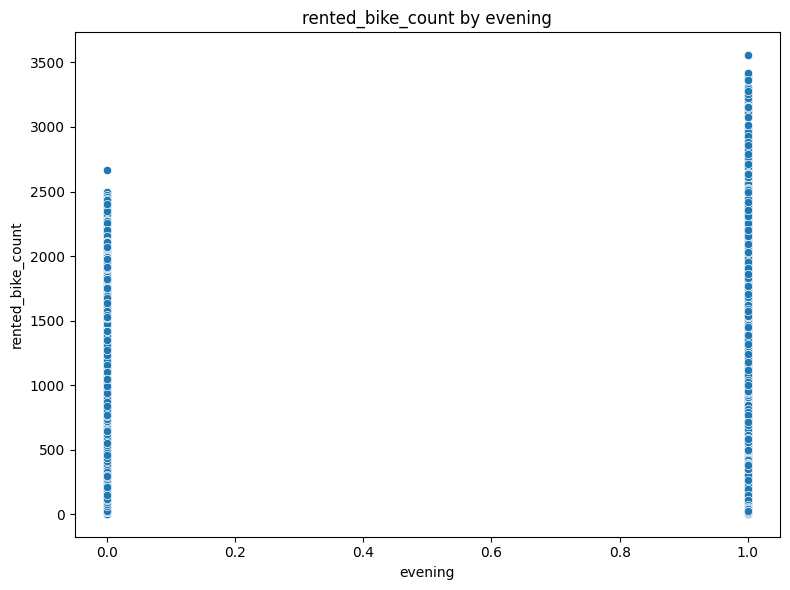

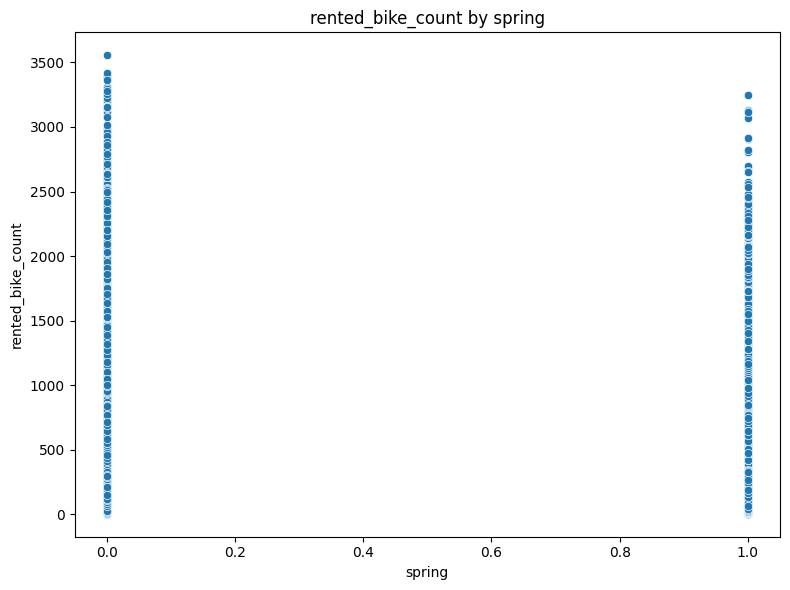

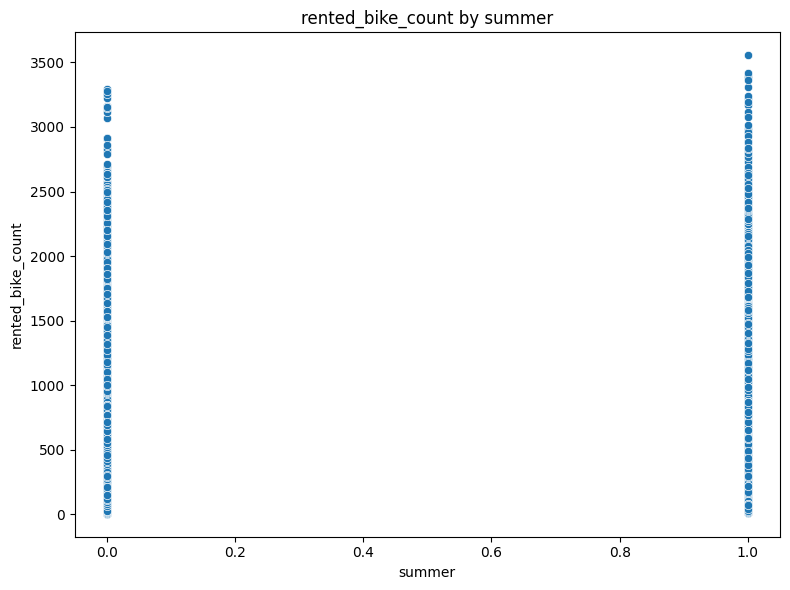

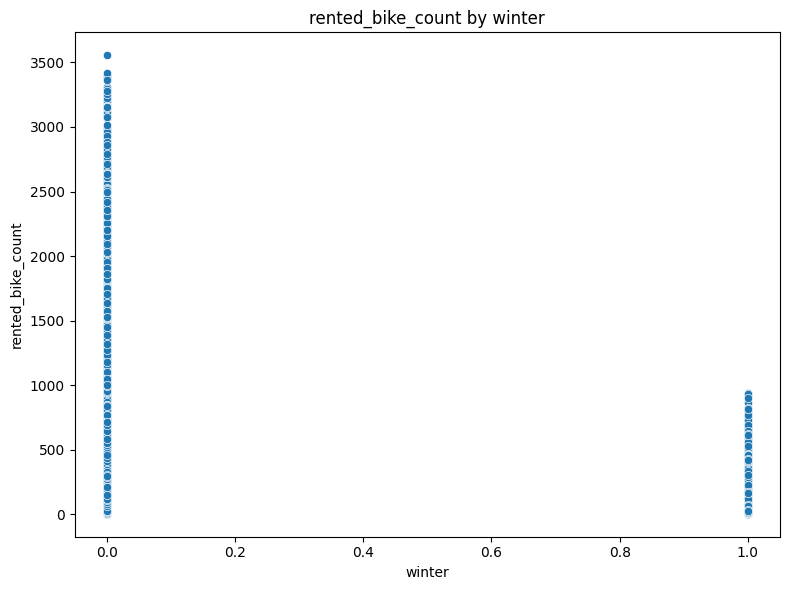

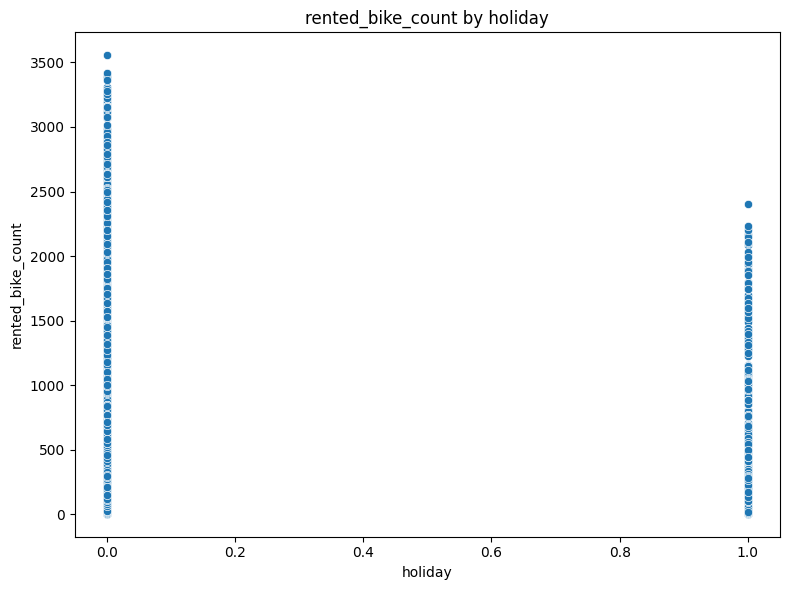

In [ ]:
# Посмотрим на динамику целевого признака в разрезе остальных признаков.
target_feature_dynamics(df_grouped, 'rented_bike_count')

### Вывод

Вывод:
* Phik улавливает достаточно сильную корреляцию(свыше 0.6) целевого признака с 'solar_radiation_(mj/m2)'. Также наблюдается средняя корреляция с 'winter', 'hour' / ('evening', 'afternoon'), 'temperature(°c)', 'summer'. Корреляция с
 'wind_speed_(m/s)', 'visibility_(10m)', 'dew_point_temperature(°c)',
 'rainfall(mm)', 'snowfall_(cm)', 'sunday', 'thursday', 'tuesday','wednesday','holiday' совсем отсутвуют.
* Кендалл и Спирмен показывают самую высокую корреляцию с 'temperature(°c)' и 'winter'.
* Присутствуют мультиколиарные признаки:
    - сезоны года и температурные показатели ('temperature(°c)' - 'summer',
     'temperature(°c)' - 'winter',
     'dew_point_temperature(°c)' - 'summer',
     'dew_point_temperature(°c)' - 'winter')
    - температурные показатели: 'temperature(°c)' - 'dew_point_temperature(°c)'
    - солнечной радиации от времени суток: 'hour'/ 'afternoon' - 'solar_radiation_(mj/m2)'



## EDA итоги

* Ввиду сильной мультиколиарности можно исклюяить из обучения признаки:
  - 'dew_point_temperature(°c)'
  - 'summer'
  - 'winter'
  - 'spring'

* Признак 'solar_radiation_(mj/m2)' пока можно оставить для проверки поскольку он сильно коррелируется только с послеобеденными часами, в остальные часы (периоды) мультиколлиарность не наблюдается.

In [ ]:
# сделаем копию рабочего датафрейма для сохранения данных
df_base = df.copy()
df_grouped_base = df_grouped.copy()

# Обучение моделей

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model # модуль, содержащий линейную регрессию
from sklearn import metrics  # модуль содержащий метрики
import numpy as np
from sklearn import model_selection
from sklearn import tree

In [ ]:
# вся обработанная информация хранится в df_base и df_grouped_base дальше для удобства продолжим работать с df и df_grouped
df = df_base.copy()
df_grouped = df_grouped_base.copy()

In [ ]:
#columns_to_drop = ['dew_point_temperature(°c)', 'summer', 'winter', 'spring']
columns_to_drop = ['dew_point_temperature(°c)']

df.drop(columns=columns_to_drop, axis=1, inplace=True)
df.head(3)

rented_bike_count  hour  temperature(°c)  humidity(%)  wind_speed_(m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   

   visibility_(10m)  solar_radiation_(mj/m2)  rainfall(mm)  snowfall_(cm)  \
0              2000                      0.0           0.0            0.0   
1              2000                      0.0           0.0            0.0   
2              2000                      0.0           0.0            0.0   

   monday  saturday  sunday  thursday  tuesday  wednesday  spring  summer  \
0       0         0       0         0        0          0       0       0   
1       0         0       0         0        0          0       0       0   
2       0         0       0         0        0          0       0       0   

   winter  holiday  
0       1        0  
1       1        0  
2       1        0

In [ ]:
#columns_to_drop = ['dew_point_temperature(°c)', 'summer', 'winter', 'spring']
columns_to_drop = ['dew_point_temperature(°c)']

df_grouped.drop(columns=columns_to_drop, axis=1, inplace=True)
df_grouped.head(3)

rented_bike_count  temperature(°c)  humidity(%)  wind_speed_(m/s)  \
0                254             -5.2           37               2.2   
1                204             -5.5           38               0.8   
2                173             -6.0           39               1.0   

   visibility_(10m)  solar_radiation_(mj/m2)  rainfall(mm)  snowfall_(cm)  \
0              2000                      0.0           0.0            0.0   
1              2000                      0.0           0.0            0.0   
2              2000                      0.0           0.0            0.0   

   monday  saturday  ...  thursday  tuesday  wednesday  morning  afternoon  \
0       0         0  ...         0        0          0        0          0   
1       0         0  ...         0        0          0        0          0   
2       0         0  ...         0        0          0        0          0   

   evening  spring  summer  winter  holiday  
0        0       0       0       1        0  
1        0       0       0       1        0  
2        0       0       0       1        0  

[3 rows x 21 columns]

In [ ]:
# создадим датафрейм, куда будем вносить получившиеся модели
import pandas as pd
from sklearn import metrics

# Создание датафрейма
models_df = pd.DataFrame(columns=['Модель', 'Adjusted R2', 'RMSE', 'Время обучения', 'Особые параметры модели'])

## Функции

In [ ]:
# Функция для расчёта Adjusted R2

import sklearn.metrics as metrics

def adjusted_r2_score(y, y_pred, X):
    r2 = metrics.r2_score(y, y_pred)
    n = X.shape[0]
    k = X.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return adjusted_r2


## Baseline модель

### df

In [ ]:
X = df.drop('rented_bike_count', axis=1)
y = df['rented_bike_count']

In [ ]:
# разделим выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Создаем модель линейной регрессии
baseline_df = linear_model.LinearRegression()

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict = model_selection.cross_val_predict(estimator=baseline_df, X=X_train, y=y_train, cv=10)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=baseline_df, X=X_test, y=y_test, cv=10)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))


# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(baseline_df, X, y, cv=5, scoring='r2', return_train_score=True)

# Время выполнения обучения для каждого фолда
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 0.01 seconds
****************************************
Train Adjusted R2 (CV): 0.538
Test Adjusted R2 (CV): 0.547
****************************************
Train RMSE (CV): 439
Test RMSE (CV): 421


In [ ]:
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['baseline_df'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Время обучения': [fit_time_mean]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения Особые параметры модели
0  baseline_df        0.547  421            0.01                     NaN

### df_grouped

In [ ]:
X = df_grouped.drop('rented_bike_count', axis=1)
y = df_grouped['rented_bike_count']

In [ ]:
# разделим выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Создаем модель линейной регрессии
baseline_df_grouped = linear_model.LinearRegression()

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict = model_selection.cross_val_predict(estimator=baseline_df_grouped, X=X_train, y=y_train, cv=10)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=baseline_df_grouped, X=X_test, y=y_test, cv=10)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))


# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(baseline_df_grouped, X, y, cv=10, scoring='r2', return_train_score=True)

# Время выполнения обучения для каждого фолда
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 0.02 seconds
****************************************
Train Adjusted R2 (CV): 0.572
Test Adjusted R2 (CV): 0.577
****************************************
Train RMSE (CV): 422
Test RMSE (CV): 407


In [ ]:
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['baseline_df_grouped'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Время обучения': [fit_time_mean]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0          baseline_df        0.547  421            0.01   
1  baseline_df_grouped        0.577  407            0.02   

  Особые параметры модели  
0                     NaN  
1                     NaN

### df_s

In [ ]:
#df.columns.tolist()

In [ ]:
X = df.drop(['rented_bike_count', 'wind_speed_(m/s)', 'visibility_(10m)', 'snowfall_(cm)',  'monday',
 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday'], axis=1)
y = df['rented_bike_count']
X.head(3)

hour  temperature(°c)  humidity(%)  solar_radiation_(mj/m2)  rainfall(mm)  \
0     0             -5.2           37                      0.0           0.0   
1     1             -5.5           38                      0.0           0.0   
2     2             -6.0           39                      0.0           0.0   

   spring  summer  winter  holiday  
0       0       0       1        0  
1       0       0       1        0  
2       0       0       1        0

In [ ]:
# разделим выборки
X_train_s, X_test_s, y_train_s, y_test_s = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Создаем модель линейной регрессии
baseline_df_s = linear_model.LinearRegression()

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict_s = model_selection.cross_val_predict(estimator=baseline_df_s, X=X_train_s, y=y_train_s, cv=10)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict_s = model_selection.cross_val_predict(estimator=baseline_df_s, X=X_test_s, y=y_test_s, cv=10)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict_s, X_train_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict_s, X_test_s), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict_s)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict_s)))


# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(baseline_df_s, X, y, cv=5, scoring='r2', return_train_score=True)

# Время выполнения обучения для каждого фолда
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 0.02 seconds
****************************************
Train Adjusted R2 (CV): 0.533
Test Adjusted R2 (CV): 0.548
****************************************
Train RMSE (CV): 442
Test RMSE (CV): 422


In [ ]:
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['baseline_df_s'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Время обучения': [fit_time_mean]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0          baseline_df        0.547  421            0.01   
1  baseline_df_grouped        0.577  407            0.02   
2        baseline_df_s        0.548  422            0.02   

  Особые параметры модели  
0                     NaN  
1                     NaN  
2                     NaN

### df_grouped_s

In [ ]:
#df_grouped.columns.tolist()

In [ ]:
X = df_grouped.drop(['rented_bike_count', 'wind_speed_(m/s)', 'visibility_(10m)', 'snowfall_(cm)',  'monday',
 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday'], axis=1)
y = df_grouped['rented_bike_count']
X.head(3)

temperature(°c)  humidity(%)  solar_radiation_(mj/m2)  rainfall(mm)  \
0             -5.2           37                      0.0           0.0   
1             -5.5           38                      0.0           0.0   
2             -6.0           39                      0.0           0.0   

   morning  afternoon  evening  spring  summer  winter  holiday  
0        0          0        0       0       0       1        0  
1        0          0        0       0       0       1        0  
2        0          0        0       0       0       1        0

In [ ]:
# разделим выборки
X_train_s, X_test_s, y_train_s, y_test_s = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

# Создаем модель линейной регрессии
baseline_df_grouped_s = linear_model.LinearRegression()

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict_s = model_selection.cross_val_predict(estimator=baseline_df_grouped_s, X=X_train_s, y=y_train_s, cv=10)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict_s = model_selection.cross_val_predict(estimator=baseline_df_grouped_s, X=X_test_s, y=y_test_s, cv=10)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict_s, X_train_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict_s, X_test_s), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict_s)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict_s)))


# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(baseline_df_grouped_s, X, y, cv=5, scoring='r2', return_train_score=True)

# Время выполнения обучения для каждого фолда
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 0.02 seconds
****************************************
Train Adjusted R2 (CV): 0.567
Test Adjusted R2 (CV): 0.578
****************************************
Train RMSE (CV): 425
Test RMSE (CV): 407


In [ ]:
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['baseline_df_grouped_s'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Время обучения': [fit_time_mean]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0            baseline_df        0.547  421            0.01   
1    baseline_df_grouped        0.577  407            0.02   
2          baseline_df_s        0.548  422            0.02   
3  baseline_df_grouped_s        0.578  407            0.02   

  Особые параметры модели  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN

### Экспериментальным путём было установлено, что:
* Датафрейм с объёдинёнными часами по периодам (df_grouped) лучше подходит для обучения логистических моделей, поэтому в дальнейшем он будет использоваться для логистических моделей;
* Признаки 'wind_speed_(m/s)', 'visibility_(10m)', 'snowfall_(cm)',  'monday',
 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday' не оказывают влияния на силу модели, поэтому далее для построения логистических моделей эти данные будут исключены.

## Сравнение базовых моделей

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree

In [ ]:
X = df_grouped.drop(['rented_bike_count', 'wind_speed_(m/s)', 'visibility_(10m)', 'snowfall_(cm)',  'monday',
 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday'], axis=1)
y = df_grouped['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X = df_grouped.drop('rented_bike_count', axis=1)
y = df_grouped['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X = df.drop(['rented_bike_count', 'wind_speed_(m/s)', 'visibility_(10m)', 'snowfall_(cm)',  'monday',
 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday'], axis=1)
y = df['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
X = df.drop('rented_bike_count', axis=1)
y = df['rented_bike_count']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)
# самый лучший результат для случайного леса (adjusted r2 0.85)

### деревья решений

In [ ]:
# дерево решений без масштабирования

dt = tree.DecisionTreeRegressor(random_state=42)


# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
%time y_train_predict = model_selection.cross_val_predict(estimator=dt, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=dt, X=X_test, y=y_test, cv=5)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CPU times: user 5.3 s, sys: 1.15 s, total: 6.45 s
Wall time: 8 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


****************************************
Train Adjusted R2 (CV): 0.636
Test Adjusted R2 (CV): 0.514
****************************************
Train RMSE (CV): 390
Test RMSE (CV): 436


In [ ]:
# Pipline со нормализацией для дерева решений

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', tree.DecisionTreeRegressor(random_state=42))])


# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
%time y_train_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_test, y=y_test, cv=5)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CPU times: user 4.86 s, sys: 788 ms, total: 5.64 s
Wall time: 5.64 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


****************************************
Train Adjusted R2 (CV): 0.639
Test Adjusted R2 (CV): 0.508
****************************************
Train RMSE (CV): 388
Test RMSE (CV): 439


### случайный лес

In [ ]:
# случайный лес без масштабирования

rf = RandomForestRegressor(random_state=42)

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
%time y_train_predict = model_selection.cross_val_predict(estimator=rf, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=rf, X=X_test, y=y_test, cv=5)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 14.4 s, sys: 18.5 ms, total: 14.4 s
Wall time: 14.6 s
****************************************
Train Adjusted R2 (CV): 0.918
Test Adjusted R2 (CV): 0.861
****************************************
Train RMSE (CV): 185
Test RMSE (CV): 233


In [ ]:
# Pipline с нормализацией для случайного леса

pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', RandomForestRegressor(random_state=42))])

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
%time y_train_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_test, y=y_test, cv=5)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 14.3 s, sys: 18.3 ms, total: 14.3 s
Wall time: 14.4 s
****************************************
Train Adjusted R2 (CV): 0.919
Test Adjusted R2 (CV): 0.861
****************************************
Train RMSE (CV): 184
Test RMSE (CV): 234


### линейная регрессия

In [ ]:
# линейная регрессия без масштабирования

reg = linear_model.LinearRegression()

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
%time y_train_predict = model_selection.cross_val_predict(estimator=reg, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=reg, X=X_test, y=y_test, cv=5)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 98.2 ms, sys: 155 ms, total: 253 ms
Wall time: 137 ms
****************************************
Train Adjusted R2 (CV): 0.539
Test Adjusted R2 (CV): 0.548
****************************************
Train RMSE (CV): 439
Test RMSE (CV): 421


In [ ]:
# Pipline с нормализацией для дерева решений

pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', linear_model.LinearRegression())])

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
%time y_train_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=pipeline, X=X_test, y=y_test, cv=5)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

CPU times: user 118 ms, sys: 80 ms, total: 198 ms
Wall time: 104 ms
****************************************
Train Adjusted R2 (CV): 0.539
Test Adjusted R2 (CV): 0.548
****************************************
Train RMSE (CV): 439
Test RMSE (CV): 421


### Промежуточные итоги

* Масштабирование данных почти не влияет на силу моделей, но результат не ухудшает;
* Луший результат показывает случайный лес на дафрейме с информацией о часах(датафрейм df):
  - Train Adjusted R2 (CV): 0.905 - Test Adjusted R2 (CV): 0.852
  - Train RMSE (CV): 199 - Test RMSE (CV): 241;

## Случайный лес

### Обучение на всех признаках

Попробуем подобрать самые оптимальные гиперпараметры и повысить предсказательную силу модели

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn import tree

In [ ]:
X = df.drop('rented_bike_count', axis=1)
y = df['rented_bike_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# обучим базовую модель случайного леса
from sklearn.preprocessing import StandardScaler

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_base = RandomForestRegressor(random_state=42)

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict = model_selection.cross_val_predict(estimator=rf_base, X=X_train_scaled, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=rf_base, X=X_test_scaled, y=y_test, cv=5)

# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train_scaled), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test_scaled), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(rf_base, X_train_scaled, y_train, cv=5, scoring='r2', return_train_score=True)

# Вычисляем среднее время обучения модели
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 2.81 seconds
****************************************
Train Adjusted R2 (CV): 0.918
Test Adjusted R2 (CV): 0.861
****************************************
Train RMSE (CV): 185
Test RMSE (CV): 233


In [ ]:
# добавим получишвиеся метрики в таблицу для сравнения
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['rf_base'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Время обучения': [fit_time_mean]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0            baseline_df        0.547  421            0.01   
1    baseline_df_grouped        0.577  407            0.02   
2          baseline_df_s        0.548  422            0.02   
3  baseline_df_grouped_s        0.578  407            0.02   
4                rf_base        0.861  233            2.81   

  Особые параметры модели  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN

In [ ]:
# Посмотрим на глубину деревьев

# Создание и обучение случайного леса
rf_base.fit(X_train, y_train)
all_trees = rf_base.estimators_

depths = [tree.tree_.max_depth for tree in all_trees if tree.tree_ is not None]  # проверка на None
average_depth = np.mean(depths) if depths else None  # условная проверка перед вычислением средней глубины

print(f"Глубина каждого дерева: {depths}")
print(f"Средняя глубина случайного леса: {average_depth}")

Глубина каждого дерева: [27, 29, 28, 29, 27, 28, 31, 28, 26, 30, 31, 26, 27, 26, 27, 26, 29, 29, 27, 27, 27, 26, 31, 30, 26, 28, 26, 29, 28, 28, 26, 30, 27, 29, 29, 28, 24, 26, 26, 27, 27, 27, 28, 26, 27, 28, 25, 27, 28, 28, 27, 28, 27, 26, 27, 28, 25, 28, 27, 26, 29, 29, 27, 29, 29, 26, 28, 29, 28, 28, 28, 27, 29, 28, 27, 27, 28, 28, 28, 26, 30, 28, 27, 28, 27, 30, 28, 27, 28, 28, 27, 27, 27, 30, 28, 29, 27, 27, 28, 26]
Средняя глубина случайного леса: 27.64


In [ ]:
leaf_counts = [tree.tree_.n_leaves for tree in all_trees]
average_leaf_count = np.mean(leaf_counts)
print(f"Количество листьев в каждом дереве: {leaf_counts}")
print(f"Среднее количество листьев в дерерве: {average_leaf_count}")

Количество листьев в каждом дереве: [3953, 4004, 3966, 3977, 3945, 4018, 3939, 3961, 3961, 4020, 3972, 3939, 3934, 3926, 3960, 3907, 3940, 3910, 3960, 3946, 3982, 3929, 3964, 3983, 3980, 3962, 3970, 3992, 3910, 3959, 3979, 4032, 3984, 3946, 3945, 4027, 3994, 3989, 3894, 3955, 3919, 3905, 3975, 3962, 3989, 3901, 3980, 3948, 3968, 3962, 4014, 3978, 3990, 3942, 3973, 3955, 3921, 3951, 3912, 3945, 3982, 3973, 3969, 3957, 3977, 3939, 3974, 3916, 3926, 3946, 3936, 3953, 3935, 3921, 3950, 3957, 3929, 3983, 3997, 3949, 3974, 3961, 3975, 3978, 3961, 3940, 3960, 3982, 3915, 3959, 3957, 3957, 4018, 3940, 3891, 3910, 3967, 3962, 3980, 4002]
Среднее количество листьев в дерерве: 3958.62


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'hour'),
  Text(1, 0, 'temperature(°c)'),
  Text(2, 0, 'humidity(%)'),
  Text(3, 0, 'wind_speed_(m/s)'),
  Text(4, 0, 'visibility_(10m)'),
  Text(5, 0, 'solar_radiation_(mj/m2)'),
  Text(6, 0, 'rainfall(mm)'),
  Text(7, 0, 'snowfall_(cm)'),
  Text(8, 0, 'monday'),
  Text(9, 0, 'saturday'),
  Text(10, 0, 'sunday'),
  Text(11, 0, 'thursday'),
  Text(12, 0, 'tuesday'),
  Text(13, 0, 'wednesday'),
  Text(14, 0, 'spring'),
  Text(15, 0, 'summer'),
  Text(16, 0, 'winter'),
  Text(17, 0, 'holiday')])

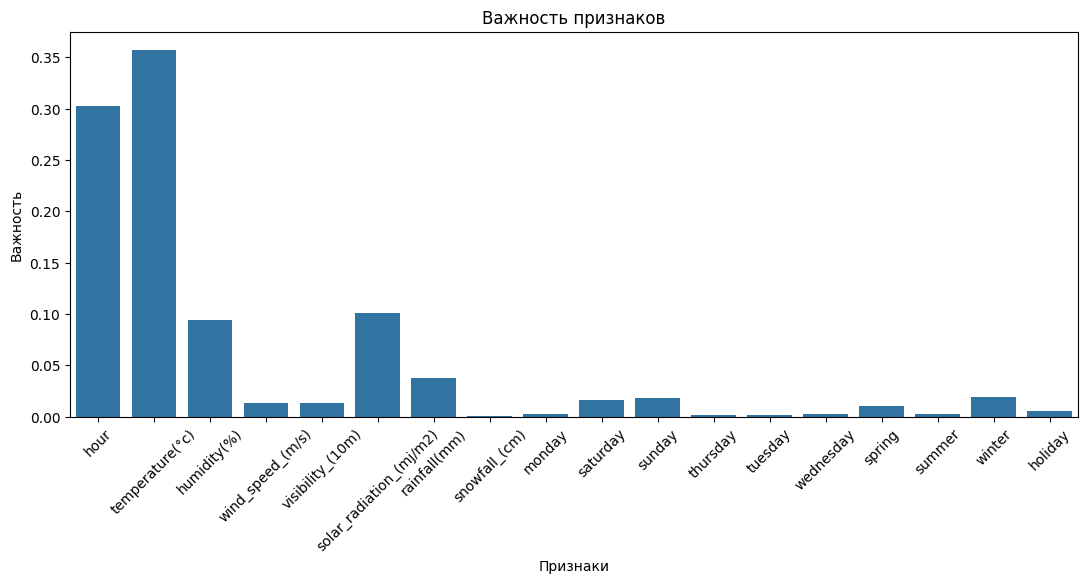

In [ ]:
# посмотрим на важность признаков
rf_base.fit(X_train, y_train)
plt.figure(figsize=(13, 5))
feature = X_train.columns
feature_importances = rf_base.feature_importances_
sns.barplot(x=feature, y=feature_importances);
#Добавляем подпись графику, осям абсцисс и ординат
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=45)

Попробуем подобрать оптимальные гиперпараметры модели

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from hyperopt import hp, fmin, tpe, Trials
import numpy as np

# Обновленные параметры
space = {
    'min_samples_leaf': hp.quniform('min_samples_leaf', 4, 30, 2),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'max_depth': hp.quniform('max_depth', 6, 30, 2),
    'criterion': hp.choice('criterion', ['squared_error', 'friedman_mse', 'poisson'])
}

random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': params['max_features'],
        'max_depth': int(params['max_depth']),
        'criterion': params['criterion']
    }
    model = RandomForestRegressor(**params, random_state=random_state)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_rf,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(random_state)
           )

print(f"Наилучшие значения гиперпараметров: {best}")

  2%|▏         | 2/100 [00:07<05:43,  3.51s/trial, best loss: -0.8254327306515036]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



  3%|▎         | 3/100 [00:16<09:36,  5.94s/trial, best loss: -0.890563919108021] 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



  6%|▌         | 6/100 [00:30<07:06,  4.53s/trial, best loss: -0.890563919108021]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 11%|█         | 11/100 [00:52<05:57,  4.02s/trial, best loss: -0.890563919108021]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 14%|█▍        | 14/100 [01:06<05:55,  4.14s/trial, best loss: -0.890563919108021]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 18%|█▊        | 18/100 [01:22<05:06,  3.74s/trial, best loss: -0.890563919108021]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 20%|██        | 20/100 [01:35<06:27,  4.85s/trial, best loss: -0.890563919108021]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 21%|██        | 21/100 [01:44<07:56,  6.03s/trial, best loss: -0.890563919108021]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 22%|██▏       | 22/100 [01:53<09:05,  7.00s/trial, best loss: -0.890563919108021]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 23%|██▎       | 23/100 [02:05<10:48,  8.43s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 24%|██▍       | 24/100 [02:15<11:12,  8.85s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 25%|██▌       | 25/100 [02:25<11:33,  9.24s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 26%|██▌       | 26/100 [02:36<12:10,  9.87s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 28%|██▊       | 28/100 [02:47<08:59,  7.49s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 29%|██▉       | 29/100 [02:54<08:49,  7.46s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 30%|███       | 30/100 [03:06<10:05,  8.65s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 31%|███       | 31/100 [03:15<09:57,  8.66s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 33%|███▎      | 33/100 [03:28<08:10,  7.32s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 34%|███▍      | 34/100 [03:36<08:21,  7.60s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 35%|███▌      | 35/100 [03:46<09:06,  8.41s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 36%|███▌      | 36/100 [03:56<09:27,  8.87s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 38%|███▊      | 38/100 [04:07<07:04,  6.85s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 39%|███▉      | 39/100 [04:18<08:18,  8.17s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 41%|████      | 41/100 [04:30<06:48,  6.93s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 42%|████▏     | 42/100 [04:37<06:34,  6.81s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 43%|████▎     | 43/100 [04:46<07:04,  7.45s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 46%|████▌     | 46/100 [05:02<05:06,  5.68s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 48%|████▊     | 48/100 [05:15<05:00,  5.79s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 50%|█████     | 50/100 [05:28<05:00,  6.01s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 52%|█████▏    | 52/100 [05:36<03:52,  4.85s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 54%|█████▍    | 54/100 [05:50<04:17,  5.59s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 55%|█████▌    | 55/100 [06:01<05:18,  7.07s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 58%|█████▊    | 58/100 [06:17<03:49,  5.46s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 59%|█████▉    | 59/100 [06:27<04:36,  6.75s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 60%|██████    | 60/100 [06:37<05:16,  7.91s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 63%|██████▎   | 63/100 [06:54<03:37,  5.88s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 64%|██████▍   | 64/100 [07:02<04:00,  6.69s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 65%|██████▌   | 65/100 [07:08<03:43,  6.38s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 66%|██████▌   | 66/100 [07:18<04:19,  7.62s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 67%|██████▋   | 67/100 [07:29<04:40,  8.50s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 68%|██████▊   | 68/100 [07:40<04:54,  9.20s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 69%|██████▉   | 69/100 [07:49<04:45,  9.21s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 70%|███████   | 70/100 [08:00<04:51,  9.72s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 71%|███████   | 71/100 [08:12<04:58, 10.30s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 72%|███████▏  | 72/100 [08:20<04:29,  9.62s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 73%|███████▎  | 73/100 [08:30<04:26,  9.89s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 74%|███████▍  | 74/100 [08:42<04:31, 10.43s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 75%|███████▌  | 75/100 [08:50<04:05,  9.84s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 76%|███████▌  | 76/100 [08:59<03:50,  9.61s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 79%|███████▉  | 79/100 [09:14<02:08,  6.10s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 80%|████████  | 80/100 [09:25<02:26,  7.32s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 82%|████████▏ | 82/100 [09:36<01:55,  6.39s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 83%|████████▎ | 83/100 [09:47<02:08,  7.55s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 85%|████████▌ | 85/100 [10:00<01:41,  6.75s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 87%|████████▋ | 87/100 [10:11<01:16,  5.86s/trial, best loss: -0.9069671720408559]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 88%|████████▊ | 88/100 [10:24<01:36,  8.03s/trial, best loss: -0.909512864139878] 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 89%|████████▉ | 89/100 [10:31<01:26,  7.84s/trial, best loss: -0.909512864139878]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 91%|█████████ | 91/100 [10:50<01:13,  8.17s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 92%|█████████▏| 92/100 [10:58<01:05,  8.18s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 94%|█████████▍| 94/100 [11:12<00:44,  7.36s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 95%|█████████▌| 95/100 [11:25<00:44,  8.86s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 97%|█████████▋| 97/100 [11:39<00:23,  7.76s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 98%|█████████▊| 98/100 [11:48<00:16,  8.12s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



100%|██████████| 100/100 [12:03<00:00,  7.24s/trial, best loss: -0.9095684546340607]
Наилучшие значения гиперпараметров: {'criterion': 2, 'max_depth': 20.0, 'max_features': 0, 'min_samples_leaf': 4.0}


100/100 [12:55<00:00,  7.75s/trial, best loss: -0.8948430189444967]
Наилучшие значения гиперпараметров: {'criterion': 0, 'max_depth': 12.0, 'max_features': 0, 'min_samples_leaf': 6.0}

In [ ]:
best=fmin(hyperopt_rf, # наша функция
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=150, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
         )
print(f"Наилучшие значения гиперпараметров {best}")

 67%|██████▋   | 100/150 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 68%|██████▊   | 102/150 [00:14<05:16,  6.60s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 69%|██████▊   | 103/150 [00:22<05:53,  7.52s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 69%|██████▉   | 104/150 [00:35<07:15,  9.47s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 71%|███████   | 106/150 [00:49<05:43,  7.81s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 71%|███████▏  | 107/150 [00:58<05:47,  8.08s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 73%|███████▎  | 109/150 [01:11<04:44,  6.93s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 73%|███████▎  | 110/150 [01:23<05:42,  8.56s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 74%|███████▍  | 111/150 [01:33<05:43,  8.81s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 75%|███████▌  | 113/150 [01:49<04:59,  8.09s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 76%|███████▌  | 114/150 [02:00<05:24,  9.02s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 77%|███████▋  | 116/150 [02:14<04:27,  7.86s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 78%|███████▊  | 117/150 [02:23<04:26,  8.09s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 79%|███████▉  | 119/150 [02:36<03:40,  7.12s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 80%|████████  | 120/150 [02:49<04:28,  8.94s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 81%|████████▏ | 122/150 [03:03<03:28,  7.45s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 82%|████████▏ | 123/150 [03:14<03:50,  8.55s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 83%|████████▎ | 124/150 [03:21<03:31,  8.15s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 84%|████████▍ | 126/150 [03:35<02:52,  7.20s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 85%|████████▌ | 128/150 [03:50<02:34,  7.00s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 86%|████████▌ | 129/150 [04:04<03:07,  8.92s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 87%|████████▋ | 130/150 [04:15<03:10,  9.54s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 88%|████████▊ | 132/150 [04:31<02:30,  8.36s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 89%|████████▉ | 134/150 [04:46<02:02,  7.64s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 90%|█████████ | 135/150 [04:54<01:53,  7.56s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 91%|█████████ | 136/150 [05:02<01:49,  7.83s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 92%|█████████▏| 138/150 [05:18<01:30,  7.54s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 93%|█████████▎| 140/150 [05:33<01:11,  7.19s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 94%|█████████▍| 141/150 [05:45<01:17,  8.63s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 95%|█████████▍| 142/150 [05:56<01:12,  9.11s/trial, best loss: -0.9095684546340607]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 96%|█████████▌| 144/150 [06:12<00:49,  8.27s/trial, best loss: -0.9095734264927893]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 97%|█████████▋| 145/150 [06:19<00:40,  8.01s/trial, best loss: -0.9095734264927893]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 97%|█████████▋| 146/150 [06:33<00:38,  9.59s/trial, best loss: -0.9095734264927893]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 98%|█████████▊| 147/150 [06:46<00:32, 10.72s/trial, best loss: -0.9095734264927893]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 99%|█████████▊| 148/150 [06:58<00:22, 11.21s/trial, best loss: -0.9095734264927893]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 99%|█████████▉| 149/150 [07:11<00:11, 11.69s/trial, best loss: -0.9095734264927893]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



100%|██████████| 150/150 [07:22<00:00,  8.84s/trial, best loss: -0.9095734264927893]
Наилучшие значения гиперпараметров {'criterion': 2, 'max_depth': 26.0, 'max_features': 0, 'min_samples_leaf': 4.0}


In [ ]:
rf_best = RandomForestRegressor(
    random_state=42,
    criterion=['squared_error', 'friedman_mse', 'poisson'][best['criterion']],
    max_features=['auto', 'sqrt', 'log2'][best['max_features']],
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict = model_selection.cross_val_predict(estimator=rf_best, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=rf_best, X=X_test, y=y_test, cv=5)

# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(rf_best, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

# Вычисляем среднее время обучения модели
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Average fit time: 2.26 seconds
****************************************
Train Adjusted R2 (CV): 0.909
Test Adjusted R2 (CV): 0.86
****************************************
Train RMSE (CV): 194
Test RMSE (CV): 234


In [ ]:
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['rf_best'],
                        'Adjusted R2': [adjusted_r2_test],
                        'Время обучения': [fit_time_mean],
                        'RMSE': [rmse_test],
                        'Особые параметры модели':
                         ["criterion='poisson', max_depth=22, max_features='auto', min_samples_leaf=6"]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0            baseline_df        0.547  421            0.01   
1    baseline_df_grouped        0.577  407            0.02   
2          baseline_df_s        0.548  422            0.02   
3  baseline_df_grouped_s        0.578  407            0.02   
4                rf_base        0.861  233            2.81   
5                rf_best        0.860  234            2.26   

                             Особые параметры модели  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', max_depth=22, max_feature...

In [ ]:
rf_best_best = RandomForestRegressor(max_depth=12, min_samples_leaf=6)


# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict = model_selection.cross_val_predict(estimator=rf_best_best, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=rf_best_best, X=X_test, y=y_test, cv=5)

# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(rf_best_best, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

# Вычисляем среднее время обучения модели
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 1.86 seconds
****************************************
Train Adjusted R2 (CV): 0.895
Test Adjusted R2 (CV): 0.842
****************************************
Train RMSE (CV): 210
Test RMSE (CV): 249


In [ ]:
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['rf_best_best'],
                        'Adjusted R2': [adjusted_r2_test],
                        'Время обучения': [fit_time_mean],
                        'RMSE': [rmse_test],
                        'Особые параметры модели':
                         ["max_depth=12, min_samples_leaf=6"]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0            baseline_df        0.547  421            0.01   
1    baseline_df_grouped        0.577  407            0.02   
2          baseline_df_s        0.548  422            0.02   
3  baseline_df_grouped_s        0.578  407            0.02   
4                rf_base        0.861  233            2.81   
5                rf_best        0.860  234            2.26   
6           rf_best_best        0.842  249            1.86   

                             Особые параметры модели  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', max_depth=22, max_feature...  
6                   max_depth=12, min_samples_leaf=6

### Обучение на части признаков

Попробуем подобрать самые оптимальные гиперпараметры и повысить предсказательную силу модели

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn import tree

In [ ]:
X = df.drop(['rented_bike_count', 'monday', 'thursday', 'tuesday', 'wednesday'], axis=1)
y = df['rented_bike_count']
X.head(3)

hour  temperature(°c)  humidity(%)  wind_speed_(m/s)  visibility_(10m)  \
0     0             -5.2           37               2.2              2000   
1     1             -5.5           38               0.8              2000   
2     2             -6.0           39               1.0              2000   

   solar_radiation_(mj/m2)  rainfall(mm)  snowfall_(cm)  saturday  sunday  \
0                      0.0           0.0            0.0         0       0   
1                      0.0           0.0            0.0         0       0   
2                      0.0           0.0            0.0         0       0   

   spring  summer  winter  holiday  
0       0       0       1        0  
1       0       0       1        0  
2       0       0       1        0

In [ ]:
X_train_s, X_test_s, y_train_s, y_test_s = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# обучим базовую модель случайного леса
from sklearn.preprocessing import StandardScaler

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled_s = scaler.fit_transform(X_train_s)
X_test_scaled_s = scaler.transform(X_test_s)

# Создаём объект класса DecisionTreeRegressor
rf_base_s = RandomForestRegressor()

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict = model_selection.cross_val_predict(estimator=rf_base_s, X=X_train_scaled_s, y=y_train_s, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=rf_base_s, X=X_test_scaled_s, y=y_test_s, cv=5)

# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict, X_train_scaled_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict, X_test_scaled_s), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict)))

# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(rf_base_s, X_train_scaled_s, y_train_s, cv=5, scoring='r2', return_train_score=True)

# Вычисляем среднее время обучения модели
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 2.59 seconds
****************************************
Train Adjusted R2 (CV): 0.919
Test Adjusted R2 (CV): 0.864
****************************************
Train RMSE (CV): 184
Test RMSE (CV): 231


In [ ]:
# добавим получишвиеся метрики в таблицу для сравнения
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['rf_base_s'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Время обучения': [fit_time_mean]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0            baseline_df        0.547  421            0.01   
1    baseline_df_grouped        0.577  407            0.02   
2          baseline_df_s        0.548  422            0.02   
3  baseline_df_grouped_s        0.578  407            0.02   
4                rf_base        0.861  233            2.81   
5                rf_best        0.860  234            2.26   
6           rf_best_best        0.842  249            1.86   
7              rf_base_s        0.864  231            2.59   

                             Особые параметры модели  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', max_depth=22, max_feature...  
6                   max_depth=12, min_samples_leaf=6  
7                                                NaN

In [ ]:
# Посмотрим на глубину деревьев

# Создание и обучение случайного леса
rf_base_s.fit(X_train_s, y_train_s)
all_trees = rf_base_s.estimators_

depths = [tree.tree_.max_depth for tree in all_trees if tree.tree_ is not None]  # проверка на None
average_depth = np.mean(depths) if depths else None  # условная проверка перед вычислением средней глубины

print(f"Глубина каждого дерева: {depths}")
print(f"Средняя глубина случайного леса: {average_depth}")

Глубина каждого дерева: [26, 31, 26, 27, 28, 27, 26, 26, 27, 29, 26, 27, 28, 28, 27, 26, 28, 27, 28, 27, 29, 30, 27, 27, 25, 26, 28, 26, 27, 26, 28, 27, 27, 27, 27, 27, 25, 29, 30, 27, 28, 25, 28, 29, 30, 28, 27, 31, 26, 24, 31, 26, 27, 26, 27, 27, 27, 28, 26, 29, 27, 28, 29, 28, 27, 28, 29, 30, 27, 27, 27, 26, 29, 26, 28, 25, 27, 31, 28, 28, 31, 26, 28, 26, 28, 26, 26, 26, 29, 27, 27, 26, 30, 28, 27, 26, 26, 31, 28, 29]
Средняя глубина случайного леса: 27.46


In [ ]:
leaf_counts = [tree.tree_.n_leaves for tree in all_trees]
average_leaf_count = np.mean(leaf_counts)
print(f"Количество листьев в каждом дереве: {leaf_counts}")
print(f"Среднее количество листьев в дерерве: {average_leaf_count}")

Количество листьев в каждом дереве: [3926, 3908, 3955, 3926, 3963, 3930, 3954, 3974, 3964, 3905, 3964, 3967, 3950, 3982, 3923, 3998, 3930, 3968, 3924, 3942, 3970, 4015, 3977, 3926, 3971, 3955, 3941, 3936, 3949, 3978, 3976, 3966, 3964, 3933, 3990, 3954, 3962, 3927, 3956, 4001, 3948, 3945, 3959, 3961, 3987, 3972, 3974, 3983, 3933, 4001, 3957, 3972, 3980, 3981, 3963, 3932, 3976, 3987, 3977, 3966, 3959, 3970, 4035, 3928, 3980, 3903, 3954, 3959, 3994, 3982, 3943, 3950, 4001, 3987, 3950, 3945, 3922, 3901, 3986, 3937, 4007, 3936, 3994, 3973, 3996, 3951, 3995, 3969, 3965, 3971, 4046, 3905, 4007, 3904, 3944, 3942, 3966, 3971, 3939, 3983]
Среднее количество листьев в дерерве: 3961.04


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'hour'),
  Text(1, 0, 'temperature(°c)'),
  Text(2, 0, 'humidity(%)'),
  Text(3, 0, 'wind_speed_(m/s)'),
  Text(4, 0, 'visibility_(10m)'),
  Text(5, 0, 'solar_radiation_(mj/m2)'),
  Text(6, 0, 'rainfall(mm)'),
  Text(7, 0, 'snowfall_(cm)'),
  Text(8, 0, 'saturday'),
  Text(9, 0, 'sunday'),
  Text(10, 0, 'spring'),
  Text(11, 0, 'summer'),
  Text(12, 0, 'winter'),
  Text(13, 0, 'holiday')])

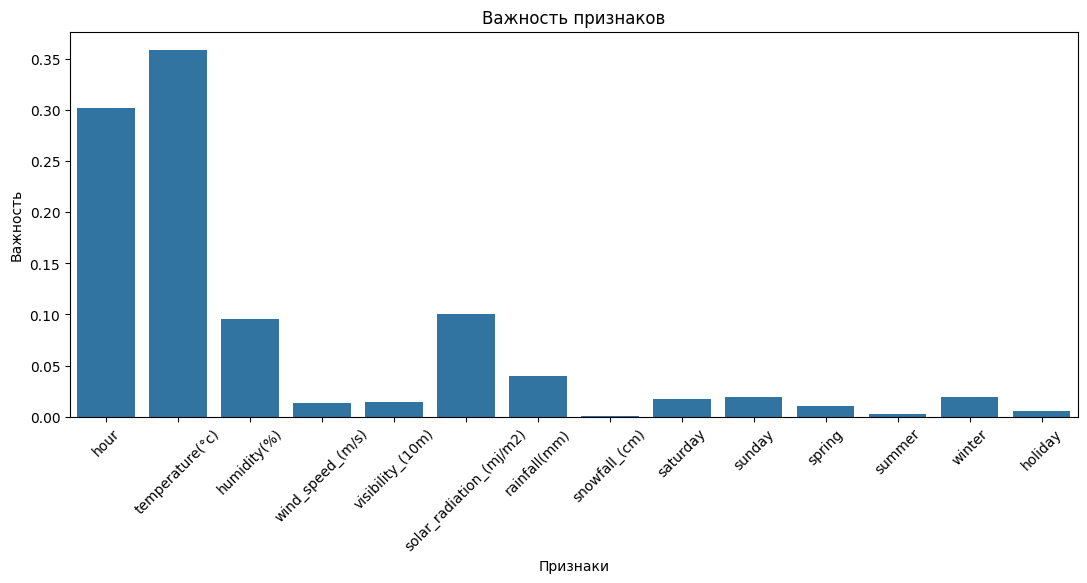

In [ ]:
# посмотрим на важность признаков
rf_base_s.fit(X_train_s, y_train_s)
plt.figure(figsize=(13, 5))
feature = X_train_s.columns
feature_importances = rf_base_s.feature_importances_
sns.barplot(x=feature, y=feature_importances);
#Добавляем подпись графику, осям абсцисс и ординат
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.xticks(rotation=45)

Попробуем подобрать оптимальные гиперпараметры модели

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from hyperopt import hp, fmin, tpe, Trials
import numpy as np

# Обновленные параметры
space = {
    'min_samples_leaf': hp.quniform('min_samples_leaf', 4, 25, 2),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'max_depth': hp.quniform('max_depth', 6, 25, 2),
    'criterion': hp.choice('criterion', ['squared_error', 'friedman_mse', 'poisson'])
}

random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_s, y=y_train_s, random_state=random_state):
    params = {
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': params['max_features'],
        'max_depth': int(params['max_depth']),
        'criterion': params['criterion']
    }
    model = RandomForestRegressor(**params, random_state=random_state)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()
    return -score

trials = Trials()
best = fmin(hyperopt_rf,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(random_state)
           )

print(f"Наилучшие значения гиперпараметров: {best}")

  2%|▏         | 2/100 [00:05<04:09,  2.54s/trial, best loss: -0.8302382818371177]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



  3%|▎         | 3/100 [00:14<09:32,  5.91s/trial, best loss: -0.8902193584179028]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



  6%|▌         | 6/100 [00:28<07:15,  4.63s/trial, best loss: -0.8902193584179028]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 11%|█         | 11/100 [00:48<05:21,  3.61s/trial, best loss: -0.8902193584179028]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 14%|█▍        | 14/100 [01:01<05:20,  3.73s/trial, best loss: -0.8902193584179028]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 18%|█▊        | 18/100 [01:16<04:46,  3.49s/trial, best loss: -0.8902193584179028]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 20%|██        | 20/100 [01:28<05:52,  4.41s/trial, best loss: -0.8902193584179028]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 21%|██        | 21/100 [01:35<06:47,  5.16s/trial, best loss: -0.8902193584179028]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 22%|██▏       | 22/100 [01:44<08:15,  6.35s/trial, best loss: -0.8902193584179028]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 23%|██▎       | 23/100 [01:53<09:24,  7.33s/trial, best loss: -0.9058778825989371]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 24%|██▍       | 24/100 [02:03<10:04,  7.96s/trial, best loss: -0.9058778825989371]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 25%|██▌       | 25/100 [02:14<11:05,  8.87s/trial, best loss: -0.9058778825989371]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 26%|██▌       | 26/100 [02:23<10:59,  8.91s/trial, best loss: -0.9058778825989371]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 28%|██▊       | 28/100 [02:35<08:44,  7.28s/trial, best loss: -0.9058778825989371]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 29%|██▉       | 29/100 [02:43<08:39,  7.31s/trial, best loss: -0.9058778825989371]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 30%|███       | 30/100 [02:51<08:56,  7.67s/trial, best loss: -0.9058778825989371]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 31%|███       | 31/100 [03:01<09:29,  8.25s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 33%|███▎      | 33/100 [03:13<07:37,  6.82s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 34%|███▍      | 34/100 [03:20<07:43,  7.02s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 35%|███▌      | 35/100 [03:28<07:54,  7.30s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 36%|███▌      | 36/100 [03:37<08:19,  7.81s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 38%|███▊      | 38/100 [03:48<06:42,  6.49s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 39%|███▉      | 39/100 [03:56<07:02,  6.93s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 41%|████      | 41/100 [04:08<05:54,  6.01s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 42%|████▏     | 42/100 [04:14<05:53,  6.10s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 43%|████▎     | 43/100 [04:24<06:50,  7.21s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 46%|████▌     | 46/100 [04:39<04:56,  5.50s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 48%|████▊     | 48/100 [04:51<04:44,  5.48s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 50%|█████     | 50/100 [05:01<04:21,  5.23s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 52%|█████▏    | 52/100 [05:11<03:52,  4.84s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 54%|█████▍    | 54/100 [05:23<03:58,  5.19s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 55%|█████▌    | 55/100 [05:32<04:40,  6.23s/trial, best loss: -0.9058779039888585]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 58%|█████▊    | 58/100 [05:49<03:47,  5.41s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 59%|█████▉    | 59/100 [05:57<04:17,  6.27s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 60%|██████    | 60/100 [06:05<04:35,  6.88s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 63%|██████▎   | 63/100 [06:20<03:13,  5.24s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 64%|██████▍   | 64/100 [06:27<03:31,  5.86s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 65%|██████▌   | 65/100 [06:35<03:51,  6.60s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 66%|██████▌   | 66/100 [06:45<04:15,  7.51s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 67%|██████▋   | 67/100 [06:54<04:21,  7.91s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 68%|██████▊   | 68/100 [07:05<04:43,  8.87s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 69%|██████▉   | 69/100 [07:15<04:44,  9.18s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 70%|███████   | 70/100 [07:24<04:31,  9.04s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 71%|███████   | 71/100 [07:33<04:29,  9.30s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 72%|███████▏  | 72/100 [07:41<04:05,  8.78s/trial, best loss: -0.9059675535857776]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 73%|███████▎  | 73/100 [07:52<04:10,  9.28s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 74%|███████▍  | 74/100 [08:02<04:08,  9.55s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 75%|███████▌  | 75/100 [08:10<03:46,  9.05s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 76%|███████▌  | 76/100 [08:20<03:49,  9.56s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 78%|███████▊  | 78/100 [08:33<02:49,  7.70s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 80%|████████  | 80/100 [08:46<02:16,  6.81s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 81%|████████  | 81/100 [08:53<02:13,  7.02s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 82%|████████▏ | 82/100 [09:03<02:22,  7.94s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 84%|████████▍ | 84/100 [09:16<01:49,  6.83s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 86%|████████▌ | 86/100 [09:28<01:29,  6.36s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 87%|████████▋ | 87/100 [09:37<01:31,  7.07s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 89%|████████▉ | 89/100 [09:51<01:12,  6.58s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 91%|█████████ | 91/100 [10:04<00:55,  6.17s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 92%|█████████▏| 92/100 [10:12<00:55,  6.88s/trial, best loss: -0.9059717830093611]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 93%|█████████▎| 93/100 [10:23<00:57,  8.16s/trial, best loss: -0.9084891206842591]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 95%|█████████▌| 95/100 [10:38<00:36,  7.34s/trial, best loss: -0.9084891206842591]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 97%|█████████▋| 97/100 [10:51<00:19,  6.52s/trial, best loss: -0.9084891206842591]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 98%|█████████▊| 98/100 [11:01<00:15,  7.82s/trial, best loss: -0.9084891206842591]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



 99%|█████████▉| 99/100 [11:09<00:07,  7.75s/trial, best loss: -0.9084891206842591]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



100%|██████████| 100/100 [11:18<00:00,  6.79s/trial, best loss: -0.9084891206842591]
Наилучшие значения гиперпараметров: {'criterion': 2, 'max_depth': 24.0, 'max_features': 0, 'min_samples_leaf': 4.0}


In [ ]:
rf_best_s = RandomForestRegressor(
    criterion=['squared_error', 'friedman_mse', 'poisson'][best['criterion']],
    max_features=['auto', 'sqrt', 'log2'][best['max_features']],
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict = model_selection.cross_val_predict(estimator=rf_best_s, X=X_train_s, y=y_train_s, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=rf_best_s, X=X_test_s, y=y_test_s, cv=5)

# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train_s, y_train_predict, X_train_s), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test_s, y_test_predict, X_test_s), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train_s, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test_s, y_test_predict)))

# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(rf_best_s, X_train_s, y_train_s, cv=5, scoring='r2', return_train_score=True)

# Вычисляем среднее время обучения модели
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Average fit time: 2.26 seconds
****************************************
Train Adjusted R2 (CV): 0.908
Test Adjusted R2 (CV): 0.857
****************************************
Train RMSE (CV): 196
Test RMSE (CV): 236


In [ ]:
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['rf_best_s'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Время обучения': [fit_time_mean],
                        'Особые параметры модели':
                         ["random_state=42, criterion='poisson', max_depth=22, max_features='auto', min_samples_leaf=6"]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0            baseline_df        0.547  421            0.01   
1    baseline_df_grouped        0.577  407            0.02   
2          baseline_df_s        0.548  422            0.02   
3  baseline_df_grouped_s        0.578  407            0.02   
4                rf_base        0.861  233            2.81   
5                rf_best        0.860  234            2.26   
6           rf_best_best        0.842  249            1.86   
7              rf_base_s        0.864  231            2.59   
8              rf_best_s        0.857  236            2.26   

                             Особые параметры модели  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', max_depth=22, max_feature...  
6                   max_depth=12, min_samples_leaf=6  
7                                                NaN  
8  random_state=42, criterion='poisson', max_dept...

## Бустинг

In [ ]:
X = df.drop('rented_bike_count', axis=1)
y = df['rented_bike_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    learning_rate=0.0125, # темп обучения
    n_estimators=350, # число деревьев
    max_depth=6,
    random_state=42
)

In [ ]:
# Выполняем кросс-валидацию и получаем предсказания для тренировочной выборки
y_train_predict = model_selection.cross_val_predict(estimator=gb, X=X_train, y=y_train, cv=5)

# Выполняем кросс-валидацию и получаем предсказания для тестовой выборки
y_test_predict = model_selection.cross_val_predict(estimator=gb, X=X_test, y=y_test, cv=5)

# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, y_train_predict, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test, y_test_predict, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_predict)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))

# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(gb, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

# Вычисляем среднее время обучения модели
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 5.66 seconds
****************************************
Train Adjusted R2 (CV): 0.909
Test Adjusted R2 (CV): 0.868
****************************************
Train RMSE (CV): 195
Test RMSE (CV): 228


In [ ]:
# Создание временного датафрейма с данными
temp_df = pd.DataFrame({'Модель': ['gb'],
                        'Adjusted R2': [adjusted_r2_test],
                        'RMSE': [rmse_test],
                        'Время обучения': [fit_time_mean],
                        'Особые параметры модели':
                         ["learning_rate=0.0115, # темп обучения, n_estimators=300, # число деревьев, max_depth=8, random_state=42"]})
# Объединение данных с помощью метода concat
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

Модель  Adjusted R2 RMSE  Время обучения  \
0            baseline_df        0.547  421            0.01   
1    baseline_df_grouped        0.577  407            0.02   
2          baseline_df_s        0.548  422            0.02   
3  baseline_df_grouped_s        0.578  407            0.02   
4                rf_base        0.861  233            2.81   
5                rf_best        0.860  234            2.26   
6           rf_best_best        0.842  249            1.86   
7              rf_base_s        0.864  231            2.59   
8              rf_best_s        0.857  236            2.26   
9                     gb        0.862  232            6.17   

                             Особые параметры модели  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5  criterion='poisson', max_depth=22, max_feature...  
6                   max_depth=12, min_samples_leaf=6  
7                                                NaN  
8  random_state=42, criterion='poisson', max_dept...  
9  learning_rate=0.0115, # темп обучения, n_estim...

In [ ]:
# Проверим работу градиентого бустинга на трейне и тесте
# Обучаем модель
gb.fit(X_train, y_train)

# Формируем предсказание для тренировочной выборки
gb_train = gb.predict(X_train)
# Формируем предсказание для тестовой выборки
gb_pred = gb.predict(X_test)


# Вычисляем adjusted R2 для кросс-валидации
adjusted_r2_train = round(adjusted_r2_score(y_train, gb_train, X_train), 3)
adjusted_r2_test = round(adjusted_r2_score(y_test,  gb_pred, X_test), 3)

# Вычисляем RMSE для кросс-валидации
rmse_train = round(np.sqrt(metrics.mean_squared_error(y_train, gb_train)))
rmse_test = round(np.sqrt(metrics.mean_squared_error(y_test, gb_pred)))

# Вычисляем среднее время обучения модели
# Проводим кросс-валидацию с расчетом времени выполнения обучения
scores = model_selection.cross_validate(gb, X_train, y_train, cv=5, scoring='r2', return_train_score=True)

# Вычисляем среднее время обучения модели
fit_time_mean = round(np.mean(scores['fit_time']), 2)

print(f"Average fit time: {fit_time_mean} seconds")
print('*' * 40)
print(f"Train Adjusted R2 (CV): {adjusted_r2_train}")
print(f"Test Adjusted R2 (CV): {adjusted_r2_test}")
print('*' * 40)
print(f"Train RMSE (CV): {rmse_train}")
print(f"Test RMSE (CV): {rmse_test}")

Average fit time: 6.15 seconds
****************************************
Train Adjusted R2 (CV): 0.968
Test Adjusted R2 (CV): 0.909
****************************************
Train RMSE (CV): 115
Test RMSE (CV): 189


# Сравнение моделей

In [ ]:
models_df.sort_values(by=['Adjusted R2', 'Время обучения'], ascending=[False, True])

Модель  Adjusted R2 RMSE  Время обучения  \
7              rf_base_s        0.864  231            2.59   
9                     gb        0.862  232            6.17   
4                rf_base        0.861  233            2.81   
5                rf_best        0.860  234            2.26   
8              rf_best_s        0.857  236            2.26   
6           rf_best_best        0.842  249            1.86   
3  baseline_df_grouped_s        0.578  407            0.02   
1    baseline_df_grouped        0.577  407            0.02   
2          baseline_df_s        0.548  422            0.02   
0            baseline_df        0.547  421            0.01   

                             Особые параметры модели  
7                                                NaN  
9  learning_rate=0.0115, # темп обучения, n_estim...  
4                                                NaN  
5  criterion='poisson', max_depth=22, max_feature...  
8  random_state=42, criterion='poisson', max_dept...  
6                   max_depth=12, min_samples_leaf=6  
3                                                NaN  
1                                                NaN  
2                                                NaN  
0                                                NaN